# LSTM /CNN / Single Neural Network를 이용한 Sentiment Classification
https://subinium.github.io/Keras-6-1/ <- 참고하면 좋을..
https://buomsoo-kim.github.io/keras/2018/05/03/Easy-deep-learning-with-Keras-9.md/ <-참고하면 좋을...2

In [21]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

import seaborn as sns
from numpy import array
from numpy import asarray
from numpy import zeros

import matplotlib.pyplot as plt

데이터의 형태가 Text와 Sentiment로 이루어진 데이터셋 Import (ex: Text, Positive)
seaborn의 countplot을 비롯하여 barplot과 distplot 등 다양한 plot기법들을 보려면 다음 링크 참조
https://brunch.co.kr/@jjason68/12

# Sentiment140
http://help.sentiment140.com/for-students
https://www.kaggle.com/kazanova/sentiment140

The data is a CSV with emoticons removed. Data file format has 6 fields: 
0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
1 - the id of the tweet (2087)
2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
3 - the query (lyx). If there is no query, then this value is NO_QUERY.
4 - the user that tweeted (robotickilldozr)
5 - the text of the tweet (Lyx is cool)

(1600000, 6)
   sentiment          id                          date query_string  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009     NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009     NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009     NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009     NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009     NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
my whole body feels itchy and like its on fire 
sentiment
0    800000
4    800000
dtype: int64


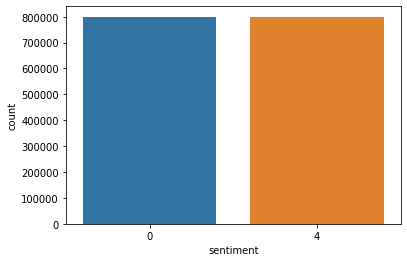

In [57]:
cols = ['sentiment','id','date','query_string','user','text']
tweets = pd.read_csv("data/sentiment140_training.1600000.processed.noemoticon.csv", encoding = 'latin-1', header = None, names = cols)
tweets.isnull().values.any()
print(str(tweets.shape))
print(str(tweets.head()))
print(str(tweets['text'][3]))
sns.countplot(x = 'sentiment', data = tweets)
print(tweets.groupby('sentiment').size())

(50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless 

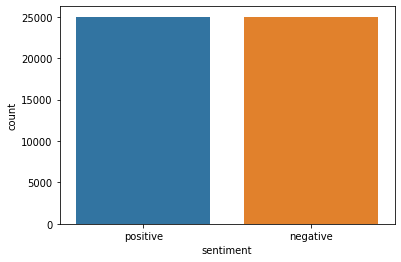

In [23]:
#Importing and Analyzing the Dataset
movie_reviews = pd.read_csv("data/IMDB Dataset.csv")
movie_reviews.isnull().values.any()

print(str(movie_reviews.shape))

print(str(movie_reviews.head()))

print(str(movie_reviews["review"][3]))

sns.countplot(x='sentiment', data=movie_reviews)

In [24]:
#Data Preprocessing
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)
#html 태그같은것들 삭제(?)

X와 Y 설정.
X는 dataset의 text에 해당하는 'review', y는 dataset의 'sentiment'

In [59]:
#논문용
X=[]
sentences = list(tweets['text'])
for sen in sentences:
    X.append(preprocess_text(sen))
y = tweets['sentiment']

#sentiment를 긍정은 1, 부정은 0으로 수정
y = np.array(list(map(lambda x: 1 if x == 4 else 0, y)))

In [60]:
print(type(X))
print(type(y))

<class 'list'>
<class 'numpy.ndarray'>


In [25]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

y = movie_reviews['sentiment']

#sentiment를 긍정은 1, 부정은 0으로 수정
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

X와 y를 훈련데이터와 테스트데이터로 나눔. 8:2로 단순히 나눔.(K-fold 교차검증은 아님. K-fold는 데이터의 수가 적을때 활용하는 방법.)
random_state는 난수 시드를 생성한다.
이 함수를 여러 번 실행해도 결과가 똑같이 나오도록 유사 난수 생성기에 넣을 난수 초깃값을 random_state 매개변수로 전달합니다. 이렇게 하면 이 코드는 항상 같은 결과를 출력합니다. 이 책에서 난수를 사용할 때는 항상 이렇게 random_state를 고정할 것입니다.(https://tensorflow.blog/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/1-7-%EC%B2%AB-%EB%B2%88%EC%A7%B8-%EC%95%A0%ED%94%8C%EB%A6%AC%EC%BC%80%EC%9D%B4%EC%85%98-%EB%B6%93%EA%BD%83%EC%9D%98-%ED%92%88%EC%A2%85-%EB%B6%84%EB%A5%98/)
자세한 K-fold에 관한 설명과 코드는 다음을 참조
https://datascienceschool.net/view-notebook/266d699d748847b3a3aa7b9805b846ae/


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

padding을 해줘야 길이가 맞춰짐. post는 뒤에다 채운다, pre는 앞에다 채운다.
https://blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221242674418&parentCategoryNo=&categoryNo=58&viewDate=&isShowPopularPosts=false&from=postView
코딩셰프의 3분 딥러닝 케라스맛
https://books.google.co.kr/books?id=LTJFDwAAQBAJ&pg=PA173&lpg=PA173&dq=pad_sequences+maxlen&source=bl&ots=m58gGDpuRX&sig=ACfU3U2TZqo2V4tN_58Kw8AZ7_La_A83sw&hl=ko&sa=X&ved=2ahUKEwjkk9Olg6zoAhXSfXAKHY-vDtE4ChDoATACegQICBAB#v=onepage&q=pad_sequences%20maxlen&f=false

In [62]:
#Preparing the Embedding Layer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

glove 를 임베딩
https://wikidocs.net/33793 <- Keras 임베딩, Glove, Word2Vec 임베딩에 관한 설명과 코드 

In [64]:
#create our feature matrix
embeddings_dictionary = dict()
glove_file = open('./embeddings/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [65]:
def train(mode):
    if (mode is 'simple'):
        #Text Classification with Simple Neural Network
        model = Sequential()
        embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
        model.add(embedding_layer)

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

    elif (mode is 'cnn'):
        #Text Classification with a Convolutional Neural Network
        model = Sequential()

        embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
        model.add(embedding_layer)

        model.add(Conv1D(128, 5, activation='relu'))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(1, activation='sigmoid'))

    elif (mode is 'lstm'):
        #Text Classification with Recurrent Neural Network (LSTM)
        model = Sequential()
        embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
        model.add(embedding_layer)
        model.add(LSTM(128))

        model.add(Dense(1, activation='sigmoid'))
    else:
        print('no matched deep learning algorithm')

    return model

In [66]:
model = train("lstm")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           50785600  
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 50,902,977
Trainable params: 117,377
Non-trainable params: 50,785,600
_________________________________________________________________
None


epoch, batchsize, iteration에 대한 설명
http://blog.naver.com/PostView.nhn?blogId=qbxlvnf11&logNo=221449297033&parentCategoryNo=&categoryNo=52&viewDate=&isShowPopularPosts=false&from=postView

In [67]:
#train our model
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
model.save("tweet_lstm_model.h5")
#evaluate the performance of the mode
score = model.evaluate(X_test, y_test, verbose=1)

Train on 1024000 samples, validate on 256000 samples
Epoch 1/6
1024000/1024000 [==============================] - 896s 875us/step - loss: 0.4780 - acc: 0.7708 - val_loss: 0.4441 - val_acc: 0.7882
Epoch 2/6
1024000/1024000 [==============================] - 907s 886us/step - loss: 0.4281 - acc: 0.8014 - val_loss: 0.4235 - val_acc: 0.8034
Epoch 3/6
1024000/1024000 [==============================] - 862s 841us/step - loss: 0.4316 - acc: 0.7989 - val_loss: 0.4874 - val_acc: 0.7660
Epoch 4/6
1024000/1024000 [==============================] - 911s 889us/step - loss: 0.4342 - acc: 0.7999 - val_loss: 0.4226 - val_acc: 0.8056
Epoch 5/6
1024000/1024000 [==============================] - 869s 849us/step - loss: 0.4120 - acc: 0.8107 - val_loss: 0.4149 - val_acc: 0.8095
Epoch 6/6
320000/320000 [==============================] - 150s 467us/step


#### 내가 추가

# 저장된 모델 가시화하고 불러와서 쓰기

모델 아키텍처 보기
model_to_dat() 함수를 통해 모델 아키텍처를 가시화 시킬 수 있습니다. model 객체를 생성한 뒤라면 언제든지 아래 코드를 호출하여 모델 아키텍처를 블록 형태로 볼 수 있습니다.

In [ ]:
# 모델 가시화하기
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

학습된 모델 불러오기
‘mnist_mlp_model.h5’에는 모델 아키텍처와 학습된 모델 가중치가 저장되어 있으니, 이를 불러와서 사용해봅니다. 코드 흐름은 다음과 같습니다.

모델 불러오는 함수를 이용하여 앞서 저장한 모델 파일로부터 모델을 재형성합니다.
실제 데이터로 모델을 사용합니다. 이 때 주로 사용되는 함수가 predict() 함수이지만 Sequential 기반의 분류 모델을 사용할 경우 좀 더 편리하게 사용할 수 있도록 predict_classes() 함수를 제공합니다. 이 함수를 이용하면 가장 확률이 높은 클래스 인덱스를 알려줍니다.
https://tykimos.tistory.com/9

In [ ]:
# 0. 사용할 패키지 불러오기
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
from numpy import argmax

# 1. 실무에 사용할 데이터 준비하기
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0
y_test = np_utils.to_categorical(y_test)
xhat_idx = np.random.choice(x_test.shape[0], 5)
xhat = x_test[xhat_idx]

# 2. 모델 불러오기
from keras.models import load_model
model = load_model('mnist_mlp_model.h5')

# 3. 모델 사용하기
yhat = model.predict_classes(xhat)

for i in range(5):
    print('True : ' + str(argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat[i]))

#### 여기까지 추가했음

Epoch와 Loss 함수 조정하기.
https://blog.naver.com/youseok0/221572203551
Early stopping하기
https://blog.naver.com/win0k/221598952238

Test Score: 0.40679145089685914
Test Accuracy: 0.8123875


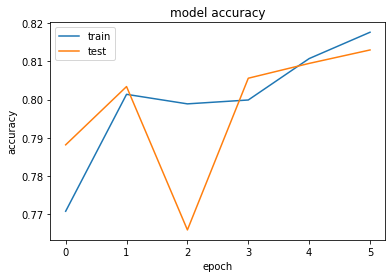

In [68]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

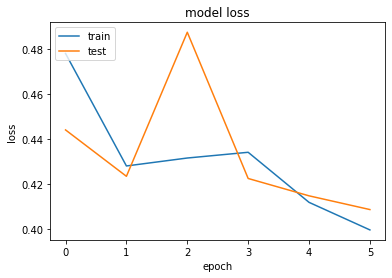

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Prediction 대상 data 불러오기

In [70]:
# Prediction 하기
dataframe = pd.read_csv("./감성값_2019현대전처리.csv", encoding = 'utf-8')
dataframe.isnull().values.any()
print(str(dataframe.shape))
print(str(dataframe.head()))
print(str(dataframe["document"][3]))
T = []
sentences = list(dataframe['document'])
for sen in sentences:
    T.append(preprocess_text(sen))

(17413, 8)
   Unnamed: 0                                           document  \
0           0  With more battery capacity and few more featur...   
1           1  2018 Hyundai Tucson SE 2.0L AWD , Leather , Su...   
2           2  2018 Hyundai Tucson SE 2.0L AWD , Leather , Su...   
3           3  I will take 30k fully load Hyundai & gt ; & gt...   
4           4         What the deal with the stupid head light ?   

                                           clean_doc  \
0  battery capacity feature ioniq could give best...   
1  hyundai tucson awd leather sunroof heated seat...   
2  hyundai tucson awd leather sunroof heated seat...   
3                       take fully load hyundai benz   
4                             deal stupid head light   

                                              nj_doc  \
0  battery capacity feature ioniq best affordable...   
1  hyundai tucson leather sunroof seats list sale...   
2  hyundai tucson leather sunroof seats list sale...   
3                  

In [63]:
#Making Predictions on Single Instance
instance = X[57]
print(instance)

instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

results = model.predict(instance)

print("predicted: " + str(results))

I have sad feeling that Dallas is not going to show up gotta say though you think more shows would use music from the game mmm
[[18], [], [1798], [165], [1648], [1072], [], [514], [165], [273], [], [1672], [1072], [1072], [1233], [18], [1029], [1386], [], [849], [1798], [165], [849], [], [273], [165], [1233], [1233], [165], [514], [], [18], [514], [], [1029], [628], [849], [], [1386], [628], [18], [1029], [1386], [], [849], [628], [], [514], [1798], [628], [1637], [], [524], [742], [], [1386], [628], [849], [849], [165], [], [514], [165], [1291], [], [849], [1798], [628], [524], [1386], [1798], [], [1291], [628], [524], [], [849], [1798], [18], [1029], [1196], [], [19], [628], [775], [1072], [], [514], [1798], [628], [1637], [514], [], [1637], [628], [524], [1233], [273], [], [524], [514], [1072], [], [19], [524], [514], [18], [737], [], [1672], [775], [628], [19], [], [849], [1798], [1072], [], [1386], [165], [19], [1072], [], [19], [19], [19]]
[[18, 1798, 165, 1648, 1072, 514, 165, 2

ValueError: Error when checking input: expected embedding_2_input to have shape (100,) but got array with shape (50,)

In [42]:
results = model.predict_classes(instance)

print("predicted: " + str(results))

predicted: [[0]]


In [76]:
results_list = []
class_list = []

for instance in T:
    instance = tokenizer.texts_to_sequences(instance)
    flat_list = []
    for sublist in instance:
        for item in sublist:
            flat_list.append(item)

    flat_list = [flat_list]

    instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

    results = model.predict(instance)
    classification = model.predict_classes(instance)
    results_list.append(results)
    class_list.append(classification)
    print("predicted: " + str(results) + "class: " + str(classification))

df = pd.DataFrame()
df['predicted'] = results_list
df['class'] = class_list
print(df)

predicted: [[0.34198764]]class: [[0]]
predicted: [[0.51738733]]class: [[1]]
predicted: [[0.51738733]]class: [[1]]
predicted: [[0.42574203]]class: [[0]]
predicted: [[0.3851964]]class: [[0]]
predicted: [[0.44049478]]class: [[0]]
predicted: [[0.39079198]]class: [[0]]
predicted: [[0.27245903]]class: [[0]]
predicted: [[0.37065473]]class: [[0]]
predicted: [[0.34387517]]class: [[0]]
predicted: [[0.47666076]]class: [[0]]
predicted: [[0.20389915]]class: [[0]]
predicted: [[0.3174248]]class: [[0]]
predicted: [[0.45266595]]class: [[0]]
predicted: [[0.30928767]]class: [[0]]
predicted: [[0.44349337]]class: [[0]]
predicted: [[0.44130924]]class: [[0]]
predicted: [[0.43423763]]class: [[0]]
predicted: [[0.44350556]]class: [[0]]
predicted: [[0.39214283]]class: [[0]]
predicted: [[0.3688339]]class: [[0]]
predicted: [[0.19805957]]class: [[0]]
predicted: [[0.19805957]]class: [[0]]
predicted: [[0.33242574]]class: [[0]]
predicted: [[0.42483318]]class: [[0]]
predicted: [[0.4512676]]class: [[0]]
predicted: [[0.4

predicted: [[0.47257602]]class: [[0]]
predicted: [[0.31370586]]class: [[0]]
predicted: [[0.19318175]]class: [[0]]
predicted: [[0.31370586]]class: [[0]]
predicted: [[0.43918365]]class: [[0]]
predicted: [[0.44175684]]class: [[0]]
predicted: [[0.5453098]]class: [[1]]
predicted: [[0.46453857]]class: [[0]]
predicted: [[0.3860446]]class: [[0]]
predicted: [[0.21161766]]class: [[0]]
predicted: [[0.3571347]]class: [[0]]
predicted: [[0.59813994]]class: [[1]]
predicted: [[0.26238102]]class: [[0]]
predicted: [[0.43384597]]class: [[0]]
predicted: [[0.36649573]]class: [[0]]
predicted: [[0.45648462]]class: [[0]]
predicted: [[0.40372184]]class: [[0]]
predicted: [[0.49376073]]class: [[0]]
predicted: [[0.44741628]]class: [[0]]
predicted: [[0.34380594]]class: [[0]]
predicted: [[0.41832286]]class: [[0]]
predicted: [[0.5058533]]class: [[1]]
predicted: [[0.523286]]class: [[1]]
predicted: [[0.27701187]]class: [[0]]
predicted: [[0.46952713]]class: [[0]]
predicted: [[0.45024967]]class: [[0]]
predicted: [[0.447

predicted: [[0.27932805]]class: [[0]]
predicted: [[0.2598973]]class: [[0]]
predicted: [[0.34302875]]class: [[0]]
predicted: [[0.4335596]]class: [[0]]
predicted: [[0.446152]]class: [[0]]
predicted: [[0.2918519]]class: [[0]]
predicted: [[0.20250164]]class: [[0]]
predicted: [[0.38120043]]class: [[0]]
predicted: [[0.22276938]]class: [[0]]
predicted: [[0.22276938]]class: [[0]]
predicted: [[0.31740275]]class: [[0]]
predicted: [[0.43872812]]class: [[0]]
predicted: [[0.36970845]]class: [[0]]
predicted: [[0.41054353]]class: [[0]]
predicted: [[0.2842895]]class: [[0]]
predicted: [[0.29385173]]class: [[0]]
predicted: [[0.383838]]class: [[0]]
predicted: [[0.3337527]]class: [[0]]
predicted: [[0.54842585]]class: [[1]]
predicted: [[0.39603215]]class: [[0]]
predicted: [[0.41609544]]class: [[0]]
predicted: [[0.4339482]]class: [[0]]
predicted: [[0.41583622]]class: [[0]]
predicted: [[0.32079482]]class: [[0]]
predicted: [[0.3846171]]class: [[0]]
predicted: [[0.3467976]]class: [[0]]
predicted: [[0.31400168]

predicted: [[0.44716692]]class: [[0]]
predicted: [[0.56368107]]class: [[1]]
predicted: [[0.27918154]]class: [[0]]
predicted: [[0.4667691]]class: [[0]]
predicted: [[0.16690207]]class: [[0]]
predicted: [[0.42224467]]class: [[0]]
predicted: [[0.2067455]]class: [[0]]
predicted: [[0.19805957]]class: [[0]]
predicted: [[0.19230877]]class: [[0]]
predicted: [[0.49231932]]class: [[0]]
predicted: [[0.47920784]]class: [[0]]
predicted: [[0.33320242]]class: [[0]]
predicted: [[0.3446353]]class: [[0]]
predicted: [[0.49231932]]class: [[0]]
predicted: [[0.49231932]]class: [[0]]
predicted: [[0.49231932]]class: [[0]]
predicted: [[0.3910619]]class: [[0]]
predicted: [[0.46887872]]class: [[0]]
predicted: [[0.3074153]]class: [[0]]
predicted: [[0.32303786]]class: [[0]]
predicted: [[0.3226785]]class: [[0]]
predicted: [[0.41172817]]class: [[0]]
predicted: [[0.20956963]]class: [[0]]
predicted: [[0.32874152]]class: [[0]]
predicted: [[0.14966664]]class: [[0]]
predicted: [[0.26479834]]class: [[0]]
predicted: [[0.282

predicted: [[0.32050502]]class: [[0]]
predicted: [[0.25112778]]class: [[0]]
predicted: [[0.35016632]]class: [[0]]
predicted: [[0.35475045]]class: [[0]]
predicted: [[0.26015192]]class: [[0]]
predicted: [[0.2775085]]class: [[0]]
predicted: [[0.5184296]]class: [[1]]
predicted: [[0.4514265]]class: [[0]]
predicted: [[0.30478963]]class: [[0]]
predicted: [[0.33696035]]class: [[0]]
predicted: [[0.37320194]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.40272853]]class: [[0]]
predicted: [[0.442057]]class: [[0]]
predicted: [[0.23012432]]class: [[0]]
predicted: [[0.2823006]]class: [[0]]
predicted: [[0.41812092]]class: [[0]]
predicted: [[0.17319115]]class: [[0]]
predicted: [[0.35941273]]class: [[0]]
predicted: [[0.37724677]]class: [[0]]
predicted: [[0.39030093]]class: [[0]]
predicted: [[0.33005336]]class: [[0]]
predicted: [[0.34354088]]class: [[0]]
predicted: [[0.32048473]]class: [[0]]
predicted: [[0.40199846]]class: [[0]]
predicted: [[0.48826435]]class: [[0]]
predicted: [[0.377

predicted: [[0.45101488]]class: [[0]]
predicted: [[0.28010768]]class: [[0]]
predicted: [[0.38726488]]class: [[0]]
predicted: [[0.43575877]]class: [[0]]
predicted: [[0.27472878]]class: [[0]]
predicted: [[0.4158613]]class: [[0]]
predicted: [[0.19448593]]class: [[0]]
predicted: [[0.51946056]]class: [[1]]
predicted: [[0.43706042]]class: [[0]]
predicted: [[0.478624]]class: [[0]]
predicted: [[0.4310988]]class: [[0]]
predicted: [[0.3982256]]class: [[0]]
predicted: [[0.4298021]]class: [[0]]
predicted: [[0.3769885]]class: [[0]]
predicted: [[0.3769885]]class: [[0]]
predicted: [[0.46857554]]class: [[0]]
predicted: [[0.2628565]]class: [[0]]
predicted: [[0.49908864]]class: [[0]]
predicted: [[0.36604923]]class: [[0]]
predicted: [[0.40619913]]class: [[0]]
predicted: [[0.41453883]]class: [[0]]
predicted: [[0.31977764]]class: [[0]]
predicted: [[0.39401376]]class: [[0]]
predicted: [[0.39401376]]class: [[0]]
predicted: [[0.2535161]]class: [[0]]
predicted: [[0.39401376]]class: [[0]]
predicted: [[0.3940137

predicted: [[0.3750142]]class: [[0]]
predicted: [[0.2775448]]class: [[0]]
predicted: [[0.4219525]]class: [[0]]
predicted: [[0.5106117]]class: [[1]]
predicted: [[0.41436666]]class: [[0]]
predicted: [[0.5058184]]class: [[1]]
predicted: [[0.43786293]]class: [[0]]
predicted: [[0.41152912]]class: [[0]]
predicted: [[0.37140572]]class: [[0]]
predicted: [[0.40140456]]class: [[0]]
predicted: [[0.5058184]]class: [[1]]
predicted: [[0.32688314]]class: [[0]]
predicted: [[0.35823646]]class: [[0]]
predicted: [[0.55393624]]class: [[1]]
predicted: [[0.3630119]]class: [[0]]
predicted: [[0.3750142]]class: [[0]]
predicted: [[0.51464033]]class: [[1]]
predicted: [[0.4773946]]class: [[0]]
predicted: [[0.54587847]]class: [[1]]
predicted: [[0.24592942]]class: [[0]]
predicted: [[0.5457365]]class: [[1]]
predicted: [[0.22887869]]class: [[0]]
predicted: [[0.37076727]]class: [[0]]
predicted: [[0.3924141]]class: [[0]]
predicted: [[0.18546677]]class: [[0]]
predicted: [[0.5058184]]class: [[1]]
predicted: [[0.22224167]

predicted: [[0.43644014]]class: [[0]]
predicted: [[0.4345658]]class: [[0]]
predicted: [[0.3937891]]class: [[0]]
predicted: [[0.3862286]]class: [[0]]
predicted: [[0.3937891]]class: [[0]]
predicted: [[0.30668747]]class: [[0]]
predicted: [[0.4154901]]class: [[0]]
predicted: [[0.52382326]]class: [[1]]
predicted: [[0.55116063]]class: [[1]]
predicted: [[0.36170846]]class: [[0]]
predicted: [[0.4404933]]class: [[0]]
predicted: [[0.46018684]]class: [[0]]
predicted: [[0.37681156]]class: [[0]]
predicted: [[0.18467599]]class: [[0]]
predicted: [[0.36654392]]class: [[0]]
predicted: [[0.24996379]]class: [[0]]
predicted: [[0.34511065]]class: [[0]]
predicted: [[0.43601358]]class: [[0]]
predicted: [[0.2608422]]class: [[0]]
predicted: [[0.5179399]]class: [[1]]
predicted: [[0.5058184]]class: [[1]]
predicted: [[0.31575537]]class: [[0]]
predicted: [[0.3342521]]class: [[0]]
predicted: [[0.31016362]]class: [[0]]
predicted: [[0.46431294]]class: [[0]]
predicted: [[0.42564568]]class: [[0]]
predicted: [[0.3101636

predicted: [[0.40660498]]class: [[0]]
predicted: [[0.43278936]]class: [[0]]
predicted: [[0.3815199]]class: [[0]]
predicted: [[0.26562423]]class: [[0]]
predicted: [[0.3750142]]class: [[0]]
predicted: [[0.4286559]]class: [[0]]
predicted: [[0.42634243]]class: [[0]]
predicted: [[0.49453002]]class: [[0]]
predicted: [[0.4206324]]class: [[0]]
predicted: [[0.35986125]]class: [[0]]
predicted: [[0.27268726]]class: [[0]]
predicted: [[0.29286304]]class: [[0]]
predicted: [[0.55393624]]class: [[1]]
predicted: [[0.41693288]]class: [[0]]
predicted: [[0.3881388]]class: [[0]]
predicted: [[0.37443528]]class: [[0]]
predicted: [[0.4239401]]class: [[0]]
predicted: [[0.34579033]]class: [[0]]
predicted: [[0.418003]]class: [[0]]
predicted: [[0.40453157]]class: [[0]]
predicted: [[0.36029366]]class: [[0]]
predicted: [[0.48934737]]class: [[0]]
predicted: [[0.27769026]]class: [[0]]
predicted: [[0.5052994]]class: [[1]]
predicted: [[0.4522014]]class: [[0]]
predicted: [[0.34108534]]class: [[0]]
predicted: [[0.501082]

predicted: [[0.4401904]]class: [[0]]
predicted: [[0.4276058]]class: [[0]]
predicted: [[0.3660164]]class: [[0]]
predicted: [[0.3653901]]class: [[0]]
predicted: [[0.41864604]]class: [[0]]
predicted: [[0.42980155]]class: [[0]]
predicted: [[0.4582152]]class: [[0]]
predicted: [[0.26818419]]class: [[0]]
predicted: [[0.31570825]]class: [[0]]
predicted: [[0.16650409]]class: [[0]]
predicted: [[0.43079627]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.37257817]]class: [[0]]
predicted: [[0.5391985]]class: [[1]]
predicted: [[0.39527857]]class: [[0]]
predicted: [[0.43423992]]class: [[0]]
predicted: [[0.42859885]]class: [[0]]
predicted: [[0.3770596]]class: [[0]]
predicted: [[0.47998315]]class: [[0]]
predicted: [[0.43925145]]class: [[0]]
predicted: [[0.38952464]]class: [[0]]
predicted: [[0.36929092]]class: [[0]]
predicted: [[0.26711962]]class: [[0]]
predicted: [[0.5361883]]class: [[1]]
predicted: [[0.449841]]class: [[0]]
predicted: [[0.5058184]]class: [[1]]
predicted: [[0.42510268

predicted: [[0.245137]]class: [[0]]
predicted: [[0.48418355]]class: [[0]]
predicted: [[0.2558035]]class: [[0]]
predicted: [[0.41864786]]class: [[0]]
predicted: [[0.14446051]]class: [[0]]
predicted: [[0.27769026]]class: [[0]]
predicted: [[0.27439526]]class: [[0]]
predicted: [[0.26988915]]class: [[0]]
predicted: [[0.28535405]]class: [[0]]
predicted: [[0.28535405]]class: [[0]]
predicted: [[0.26988915]]class: [[0]]
predicted: [[0.28535405]]class: [[0]]
predicted: [[0.26988915]]class: [[0]]
predicted: [[0.26988915]]class: [[0]]
predicted: [[0.20583023]]class: [[0]]
predicted: [[0.27428424]]class: [[0]]
predicted: [[0.53862745]]class: [[1]]
predicted: [[0.46960303]]class: [[0]]
predicted: [[0.42128295]]class: [[0]]
predicted: [[0.4862019]]class: [[0]]
predicted: [[0.41808432]]class: [[0]]
predicted: [[0.1835007]]class: [[0]]
predicted: [[0.42827347]]class: [[0]]
predicted: [[0.46317446]]class: [[0]]
predicted: [[0.48854238]]class: [[0]]
predicted: [[0.45251703]]class: [[0]]
predicted: [[0.42

predicted: [[0.395696]]class: [[0]]
predicted: [[0.4999498]]class: [[0]]
predicted: [[0.27333352]]class: [[0]]
predicted: [[0.4918914]]class: [[0]]
predicted: [[0.44963402]]class: [[0]]
predicted: [[0.5006818]]class: [[1]]
predicted: [[0.2549209]]class: [[0]]
predicted: [[0.16376919]]class: [[0]]
predicted: [[0.33557642]]class: [[0]]
predicted: [[0.4999479]]class: [[0]]
predicted: [[0.5213047]]class: [[1]]
predicted: [[0.24480593]]class: [[0]]
predicted: [[0.21446438]]class: [[0]]
predicted: [[0.26672724]]class: [[0]]
predicted: [[0.22285628]]class: [[0]]
predicted: [[0.38183466]]class: [[0]]
predicted: [[0.2988205]]class: [[0]]
predicted: [[0.24419855]]class: [[0]]
predicted: [[0.47614184]]class: [[0]]
predicted: [[0.5054896]]class: [[1]]
predicted: [[0.17630835]]class: [[0]]
predicted: [[0.45870686]]class: [[0]]
predicted: [[0.46272397]]class: [[0]]
predicted: [[0.36577204]]class: [[0]]
predicted: [[0.2127623]]class: [[0]]
predicted: [[0.36773542]]class: [[0]]
predicted: [[0.32050502

predicted: [[0.45525396]]class: [[0]]
predicted: [[0.49293777]]class: [[0]]
predicted: [[0.4859746]]class: [[0]]
predicted: [[0.43497863]]class: [[0]]
predicted: [[0.25040478]]class: [[0]]
predicted: [[0.41073248]]class: [[0]]
predicted: [[0.32470548]]class: [[0]]
predicted: [[0.39742792]]class: [[0]]
predicted: [[0.271202]]class: [[0]]
predicted: [[0.20155959]]class: [[0]]
predicted: [[0.40782112]]class: [[0]]
predicted: [[0.45016602]]class: [[0]]
predicted: [[0.2602994]]class: [[0]]
predicted: [[0.5069674]]class: [[1]]
predicted: [[0.38688836]]class: [[0]]
predicted: [[0.3272879]]class: [[0]]
predicted: [[0.28121346]]class: [[0]]
predicted: [[0.30449358]]class: [[0]]
predicted: [[0.43728104]]class: [[0]]
predicted: [[0.5561873]]class: [[1]]
predicted: [[0.42278084]]class: [[0]]
predicted: [[0.3787547]]class: [[0]]
predicted: [[0.34637907]]class: [[0]]
predicted: [[0.31752345]]class: [[0]]
predicted: [[0.20360695]]class: [[0]]
predicted: [[0.38362262]]class: [[0]]
predicted: [[0.45651

predicted: [[0.2089517]]class: [[0]]
predicted: [[0.39024296]]class: [[0]]
predicted: [[0.37199467]]class: [[0]]
predicted: [[0.38185272]]class: [[0]]
predicted: [[0.3993874]]class: [[0]]
predicted: [[0.19791123]]class: [[0]]
predicted: [[0.29054862]]class: [[0]]
predicted: [[0.48035568]]class: [[0]]
predicted: [[0.4666803]]class: [[0]]
predicted: [[0.2309534]]class: [[0]]
predicted: [[0.27309462]]class: [[0]]
predicted: [[0.3882949]]class: [[0]]
predicted: [[0.252354]]class: [[0]]
predicted: [[0.44033882]]class: [[0]]
predicted: [[0.40302604]]class: [[0]]
predicted: [[0.38859236]]class: [[0]]
predicted: [[0.28812486]]class: [[0]]
predicted: [[0.5386562]]class: [[1]]
predicted: [[0.38930595]]class: [[0]]
predicted: [[0.39239177]]class: [[0]]
predicted: [[0.4148555]]class: [[0]]
predicted: [[0.3429286]]class: [[0]]
predicted: [[0.33179948]]class: [[0]]
predicted: [[0.4252449]]class: [[0]]
predicted: [[0.48461932]]class: [[0]]
predicted: [[0.34617]]class: [[0]]
predicted: [[0.32720056]]c

predicted: [[0.42250815]]class: [[0]]
predicted: [[0.47503355]]class: [[0]]
predicted: [[0.40862465]]class: [[0]]
predicted: [[0.4827287]]class: [[0]]
predicted: [[0.40545875]]class: [[0]]
predicted: [[0.3772665]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.26721826]]class: [[0]]
predicted: [[0.42356756]]class: [[0]]
predicted: [[0.282292]]class: [[0]]
predicted: [[0.5056511]]class: [[1]]
predicted: [[0.44853556]]class: [[0]]
predicted: [[0.1582958]]class: [[0]]
predicted: [[0.27546185]]class: [[0]]
predicted: [[0.44941184]]class: [[0]]
predicted: [[0.3621557]]class: [[0]]
predicted: [[0.44410947]]class: [[0]]
predicted: [[0.38215575]]class: [[0]]
predicted: [[0.44410947]]class: [[0]]
predicted: [[0.4833914]]class: [[0]]
predicted: [[0.3653901]]class: [[0]]
predicted: [[0.36623275]]class: [[0]]
predicted: [[0.3643158]]class: [[0]]
predicted: [[0.3769885]]class: [[0]]
predicted: [[0.24180344]]class: [[0]]
predicted: [[0.40636846]]class: [[0]]
predicted: [[0.48537937

predicted: [[0.23989445]]class: [[0]]
predicted: [[0.25700152]]class: [[0]]
predicted: [[0.41580376]]class: [[0]]
predicted: [[0.48906893]]class: [[0]]
predicted: [[0.40786704]]class: [[0]]
predicted: [[0.4311735]]class: [[0]]
predicted: [[0.18023828]]class: [[0]]
predicted: [[0.4648954]]class: [[0]]
predicted: [[0.36186248]]class: [[0]]
predicted: [[0.35237795]]class: [[0]]
predicted: [[0.35872594]]class: [[0]]
predicted: [[0.21241637]]class: [[0]]
predicted: [[0.4170589]]class: [[0]]
predicted: [[0.33387032]]class: [[0]]
predicted: [[0.5343322]]class: [[1]]
predicted: [[0.35459757]]class: [[0]]
predicted: [[0.4394347]]class: [[0]]
predicted: [[0.38749167]]class: [[0]]
predicted: [[0.46242058]]class: [[0]]
predicted: [[0.40518558]]class: [[0]]
predicted: [[0.5369199]]class: [[1]]
predicted: [[0.33991647]]class: [[0]]
predicted: [[0.40658453]]class: [[0]]
predicted: [[0.5562136]]class: [[1]]
predicted: [[0.4090045]]class: [[0]]
predicted: [[0.3877831]]class: [[0]]
predicted: [[0.173956

predicted: [[0.32050502]]class: [[0]]
predicted: [[0.4417556]]class: [[0]]
predicted: [[0.24669759]]class: [[0]]
predicted: [[0.47234088]]class: [[0]]
predicted: [[0.4206324]]class: [[0]]
predicted: [[0.4268759]]class: [[0]]
predicted: [[0.4912898]]class: [[0]]
predicted: [[0.24180809]]class: [[0]]
predicted: [[0.40928853]]class: [[0]]
predicted: [[0.34950122]]class: [[0]]
predicted: [[0.36425567]]class: [[0]]
predicted: [[0.4263347]]class: [[0]]
predicted: [[0.404571]]class: [[0]]
predicted: [[0.37126297]]class: [[0]]
predicted: [[0.52111167]]class: [[1]]
predicted: [[0.44693732]]class: [[0]]
predicted: [[0.2540863]]class: [[0]]
predicted: [[0.4048112]]class: [[0]]
predicted: [[0.41499498]]class: [[0]]
predicted: [[0.44539052]]class: [[0]]
predicted: [[0.45816985]]class: [[0]]
predicted: [[0.34111163]]class: [[0]]
predicted: [[0.39553913]]class: [[0]]
predicted: [[0.51847404]]class: [[1]]
predicted: [[0.5264077]]class: [[1]]
predicted: [[0.40198624]]class: [[0]]
predicted: [[0.2081441

predicted: [[0.26537123]]class: [[0]]
predicted: [[0.3334284]]class: [[0]]
predicted: [[0.2726992]]class: [[0]]
predicted: [[0.49352086]]class: [[0]]
predicted: [[0.2956942]]class: [[0]]
predicted: [[0.37357163]]class: [[0]]
predicted: [[0.3992724]]class: [[0]]
predicted: [[0.36280313]]class: [[0]]
predicted: [[0.29164732]]class: [[0]]
predicted: [[0.36646786]]class: [[0]]
predicted: [[0.32340378]]class: [[0]]
predicted: [[0.36019194]]class: [[0]]
predicted: [[0.41906574]]class: [[0]]
predicted: [[0.3717312]]class: [[0]]
predicted: [[0.24947655]]class: [[0]]
predicted: [[0.3685118]]class: [[0]]
predicted: [[0.3633374]]class: [[0]]
predicted: [[0.34764633]]class: [[0]]
predicted: [[0.30787843]]class: [[0]]
predicted: [[0.27416575]]class: [[0]]
predicted: [[0.4075108]]class: [[0]]
predicted: [[0.379238]]class: [[0]]
predicted: [[0.5243713]]class: [[1]]
predicted: [[0.34964]]class: [[0]]
predicted: [[0.33512643]]class: [[0]]
predicted: [[0.34911856]]class: [[0]]
predicted: [[0.32715994]]c

predicted: [[0.32086855]]class: [[0]]
predicted: [[0.3709656]]class: [[0]]
predicted: [[0.4686624]]class: [[0]]
predicted: [[0.4348408]]class: [[0]]
predicted: [[0.4416586]]class: [[0]]
predicted: [[0.3989637]]class: [[0]]
predicted: [[0.37892523]]class: [[0]]
predicted: [[0.500296]]class: [[1]]
predicted: [[0.38376272]]class: [[0]]
predicted: [[0.46215323]]class: [[0]]
predicted: [[0.27758598]]class: [[0]]
predicted: [[0.20583023]]class: [[0]]
predicted: [[0.40265477]]class: [[0]]
predicted: [[0.50591147]]class: [[1]]
predicted: [[0.35433286]]class: [[0]]
predicted: [[0.33477426]]class: [[0]]
predicted: [[0.27383465]]class: [[0]]
predicted: [[0.21149084]]class: [[0]]
predicted: [[0.528951]]class: [[1]]
predicted: [[0.49231932]]class: [[0]]
predicted: [[0.33856758]]class: [[0]]
predicted: [[0.24983153]]class: [[0]]
predicted: [[0.3810463]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.36512282]]class: [[0]]
predicted: [[0.16442224]]class: [[0]]
predicted: [[0.3205050

predicted: [[0.4007922]]class: [[0]]
predicted: [[0.35154456]]class: [[0]]
predicted: [[0.20826216]]class: [[0]]
predicted: [[0.4522265]]class: [[0]]
predicted: [[0.3698776]]class: [[0]]
predicted: [[0.52727056]]class: [[1]]
predicted: [[0.38293695]]class: [[0]]
predicted: [[0.35647947]]class: [[0]]
predicted: [[0.26911506]]class: [[0]]
predicted: [[0.4728159]]class: [[0]]
predicted: [[0.36462227]]class: [[0]]
predicted: [[0.36462227]]class: [[0]]
predicted: [[0.30443648]]class: [[0]]
predicted: [[0.39226663]]class: [[0]]
predicted: [[0.41585466]]class: [[0]]
predicted: [[0.42244336]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.32451725]]class: [[0]]
predicted: [[0.28776193]]class: [[0]]
predicted: [[0.35699272]]class: [[0]]
predicted: [[0.46537554]]class: [[0]]
predicted: [[0.5066225]]class: [[1]]
predicted: [[0.3410626]]class: [[0]]
predicted: [[0.30641845]]class: [[0]]
predicted: [[0.23875327]]class: [[0]]
predicted: [[0.33880678]]class: [[0]]
predicted: [[0.482

predicted: [[0.31027597]]class: [[0]]
predicted: [[0.34389937]]class: [[0]]
predicted: [[0.28261995]]class: [[0]]
predicted: [[0.34643397]]class: [[0]]
predicted: [[0.4194474]]class: [[0]]
predicted: [[0.24000382]]class: [[0]]
predicted: [[0.3488477]]class: [[0]]
predicted: [[0.28625673]]class: [[0]]
predicted: [[0.30516472]]class: [[0]]
predicted: [[0.47225016]]class: [[0]]
predicted: [[0.28625673]]class: [[0]]
predicted: [[0.3196365]]class: [[0]]
predicted: [[0.28625673]]class: [[0]]
predicted: [[0.3788317]]class: [[0]]
predicted: [[0.46726623]]class: [[0]]
predicted: [[0.28625673]]class: [[0]]
predicted: [[0.40602288]]class: [[0]]
predicted: [[0.36089566]]class: [[0]]
predicted: [[0.4216104]]class: [[0]]
predicted: [[0.4384029]]class: [[0]]
predicted: [[0.32321024]]class: [[0]]
predicted: [[0.4216104]]class: [[0]]
predicted: [[0.34643397]]class: [[0]]
predicted: [[0.4112281]]class: [[0]]
predicted: [[0.168923]]class: [[0]]
predicted: [[0.3891675]]class: [[0]]
predicted: [[0.3151844]

predicted: [[0.33278805]]class: [[0]]
predicted: [[0.38475442]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.4196126]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.35941735]]class: [[0]]
predicted: [[0.3361512]]class: [[0]]
predicted: [[0.39967987]]class: [[0]]
predicted: [[0.42752036]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.3102697]]class: [[0]]
predicted: [[0.52965015]]class: [[1]]
predicted: [[0.35228518]]class: [[0]]
predicted: [[0.410857]]class: [[0]]
predicted: [[0.5443517]]class: [[1]]
predicted: [[0.48253864]]class: [[0]]
predicted: [[0.5283271]]class: [[1]]
predicted: [[0.23751661]]class: [[0]]
predicted: [[0.38111654]]class: [[0]]
predicted: [[0.39426145]]class: [[0]]
predicted: [[0.46450463]]class: [[0]]
predicted: [[0.3178817]]class: [[0]]
predicted: [[0.27170867]]class: [[0]]
predicted: [[0.293813]]class: [[0]]
predicted: [[0.20802942]]class: [[0]]
predicted: [[0.47222725]]class: [[0]]
predicted: [[0.4081711

predicted: [[0.3402818]]class: [[0]]
predicted: [[0.34643397]]class: [[0]]
predicted: [[0.42645428]]class: [[0]]
predicted: [[0.17106342]]class: [[0]]
predicted: [[0.38852862]]class: [[0]]
predicted: [[0.3504592]]class: [[0]]
predicted: [[0.4690634]]class: [[0]]
predicted: [[0.4830744]]class: [[0]]
predicted: [[0.3728051]]class: [[0]]
predicted: [[0.2879916]]class: [[0]]
predicted: [[0.40558612]]class: [[0]]
predicted: [[0.3519038]]class: [[0]]
predicted: [[0.32312462]]class: [[0]]
predicted: [[0.3022436]]class: [[0]]
predicted: [[0.40388212]]class: [[0]]
predicted: [[0.41215894]]class: [[0]]
predicted: [[0.4829507]]class: [[0]]
predicted: [[0.38404953]]class: [[0]]
predicted: [[0.374502]]class: [[0]]
predicted: [[0.40448353]]class: [[0]]
predicted: [[0.4160065]]class: [[0]]
predicted: [[0.37730628]]class: [[0]]
predicted: [[0.2484475]]class: [[0]]
predicted: [[0.26625425]]class: [[0]]
predicted: [[0.32816046]]class: [[0]]
predicted: [[0.23255797]]class: [[0]]
predicted: [[0.5395534]]c

predicted: [[0.40010113]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.4054435]]class: [[0]]
predicted: [[0.3583517]]class: [[0]]
predicted: [[0.41512856]]class: [[0]]
predicted: [[0.42952457]]class: [[0]]
predicted: [[0.33891016]]class: [[0]]
predicted: [[0.21206161]]class: [[0]]
predicted: [[0.351221]]class: [[0]]
predicted: [[0.38982856]]class: [[0]]
predicted: [[0.4635211]]class: [[0]]
predicted: [[0.40290275]]class: [[0]]
predicted: [[0.45264718]]class: [[0]]
predicted: [[0.44237027]]class: [[0]]
predicted: [[0.49352172]]class: [[0]]
predicted: [[0.3653752]]class: [[0]]
predicted: [[0.5005178]]class: [[1]]
predicted: [[0.43402186]]class: [[0]]
predicted: [[0.28970775]]class: [[0]]
predicted: [[0.49422807]]class: [[0]]
predicted: [[0.3820659]]class: [[0]]
predicted: [[0.23492068]]class: [[0]]
predicted: [[0.38573983]]class: [[0]]
predicted: [[0.1890441]]class: [[0]]
predicted: [[0.5800524]]class: [[1]]
predicted: [[0.45650434]]class: [[0]]
predicted: [[0.3198550

predicted: [[0.3591794]]class: [[0]]
predicted: [[0.3924661]]class: [[0]]
predicted: [[0.45542896]]class: [[0]]
predicted: [[0.28615946]]class: [[0]]
predicted: [[0.4487701]]class: [[0]]
predicted: [[0.44190302]]class: [[0]]
predicted: [[0.47238857]]class: [[0]]
predicted: [[0.422275]]class: [[0]]
predicted: [[0.4292067]]class: [[0]]
predicted: [[0.24130774]]class: [[0]]
predicted: [[0.40509084]]class: [[0]]
predicted: [[0.24257219]]class: [[0]]
predicted: [[0.32772464]]class: [[0]]
predicted: [[0.3581097]]class: [[0]]
predicted: [[0.38680765]]class: [[0]]
predicted: [[0.2786728]]class: [[0]]
predicted: [[0.33215657]]class: [[0]]
predicted: [[0.18416925]]class: [[0]]
predicted: [[0.32962862]]class: [[0]]
predicted: [[0.42553174]]class: [[0]]
predicted: [[0.49422807]]class: [[0]]
predicted: [[0.36462227]]class: [[0]]
predicted: [[0.493988]]class: [[0]]
predicted: [[0.20593494]]class: [[0]]
predicted: [[0.4272891]]class: [[0]]
predicted: [[0.3621083]]class: [[0]]
predicted: [[0.40299374]

predicted: [[0.29196066]]class: [[0]]
predicted: [[0.35053125]]class: [[0]]
predicted: [[0.5440777]]class: [[1]]
predicted: [[0.29724297]]class: [[0]]
predicted: [[0.3562791]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.4686961]]class: [[0]]
predicted: [[0.3268748]]class: [[0]]
predicted: [[0.42223412]]class: [[0]]
predicted: [[0.49811882]]class: [[0]]
predicted: [[0.4343014]]class: [[0]]
predicted: [[0.40999573]]class: [[0]]
predicted: [[0.44853044]]class: [[0]]
predicted: [[0.39292088]]class: [[0]]
predicted: [[0.4962715]]class: [[0]]
predicted: [[0.5246242]]class: [[1]]
predicted: [[0.42196357]]class: [[0]]
predicted: [[0.44926044]]class: [[0]]
predicted: [[0.2927667]]class: [[0]]
predicted: [[0.3910225]]class: [[0]]
predicted: [[0.15905416]]class: [[0]]
predicted: [[0.35179293]]class: [[0]]
predicted: [[0.3803486]]class: [[0]]
predicted: [[0.45204324]]class: [[0]]
predicted: [[0.54492277]]class: [[1]]
predicted: [[0.31673124]]class: [[0]]
predicted: [[0.4396065

predicted: [[0.32573724]]class: [[0]]
predicted: [[0.335508]]class: [[0]]
predicted: [[0.44183967]]class: [[0]]
predicted: [[0.351261]]class: [[0]]
predicted: [[0.4452464]]class: [[0]]
predicted: [[0.47561947]]class: [[0]]
predicted: [[0.43395254]]class: [[0]]
predicted: [[0.4358943]]class: [[0]]
predicted: [[0.34830683]]class: [[0]]
predicted: [[0.44863224]]class: [[0]]
predicted: [[0.32458755]]class: [[0]]
predicted: [[0.29954377]]class: [[0]]
predicted: [[0.3602022]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.27733397]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.3947983]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.41601202]]class: [[0]]
predicted: [[0.47374037]]class: [[0]]
predicted: [[0.20116043]]class: [[0]]
predicted: [[0.3540816]]class: [[0]]
predicted: [[0.36880812]]class: [[0]]
predicted: [[0.49422807]]class: [[0]]
predicted: [[0.4169684]]class: [[0]]
predicted: [[0.35306454]]class: [[0]]
predicted: [[0.1502818

predicted: [[0.3968841]]class: [[0]]
predicted: [[0.36934942]]class: [[0]]
predicted: [[0.4322426]]class: [[0]]
predicted: [[0.3669317]]class: [[0]]
predicted: [[0.37075317]]class: [[0]]
predicted: [[0.49991122]]class: [[0]]
predicted: [[0.2829498]]class: [[0]]
predicted: [[0.40563583]]class: [[0]]
predicted: [[0.19255543]]class: [[0]]
predicted: [[0.47805646]]class: [[0]]
predicted: [[0.44462475]]class: [[0]]
predicted: [[0.457447]]class: [[0]]
predicted: [[0.49445727]]class: [[0]]
predicted: [[0.42208412]]class: [[0]]
predicted: [[0.3974406]]class: [[0]]
predicted: [[0.4350603]]class: [[0]]
predicted: [[0.48415148]]class: [[0]]
predicted: [[0.3010442]]class: [[0]]
predicted: [[0.41626048]]class: [[0]]
predicted: [[0.41672948]]class: [[0]]
predicted: [[0.49245006]]class: [[0]]
predicted: [[0.4444177]]class: [[0]]
predicted: [[0.4336651]]class: [[0]]
predicted: [[0.3539251]]class: [[0]]
predicted: [[0.4917921]]class: [[0]]
predicted: [[0.36154646]]class: [[0]]
predicted: [[0.40247625]]

predicted: [[0.40919608]]class: [[0]]
predicted: [[0.20170347]]class: [[0]]
predicted: [[0.49768052]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.3366449]]class: [[0]]
predicted: [[0.49010712]]class: [[0]]
predicted: [[0.43848008]]class: [[0]]
predicted: [[0.4481457]]class: [[0]]
predicted: [[0.43009177]]class: [[0]]
predicted: [[0.44239923]]class: [[0]]
predicted: [[0.4184215]]class: [[0]]
predicted: [[0.46140364]]class: [[0]]
predicted: [[0.37371472]]class: [[0]]
predicted: [[0.31027722]]class: [[0]]
predicted: [[0.19334155]]class: [[0]]
predicted: [[0.5256204]]class: [[1]]
predicted: [[0.31022832]]class: [[0]]
predicted: [[0.2300209]]class: [[0]]
predicted: [[0.59882265]]class: [[1]]
predicted: [[0.3207379]]class: [[0]]
predicted: [[0.53371006]]class: [[1]]
predicted: [[0.37990782]]class: [[0]]
predicted: [[0.5510858]]class: [[1]]
predicted: [[0.33290195]]class: [[0]]
predicted: [[0.18069644]]class: [[0]]
predicted: [[0.41341802]]class: [[0]]
predicted: [[0.4334

predicted: [[0.3307049]]class: [[0]]
predicted: [[0.39993727]]class: [[0]]
predicted: [[0.4779313]]class: [[0]]
predicted: [[0.4692798]]class: [[0]]
predicted: [[0.50188255]]class: [[1]]
predicted: [[0.44130924]]class: [[0]]
predicted: [[0.49968252]]class: [[0]]
predicted: [[0.4196126]]class: [[0]]
predicted: [[0.5371059]]class: [[1]]
predicted: [[0.47006628]]class: [[0]]
predicted: [[0.23440084]]class: [[0]]
predicted: [[0.31551707]]class: [[0]]
predicted: [[0.38363066]]class: [[0]]
predicted: [[0.6388064]]class: [[1]]
predicted: [[0.51607615]]class: [[1]]
predicted: [[0.44405013]]class: [[0]]
predicted: [[0.46966958]]class: [[0]]
predicted: [[0.3984304]]class: [[0]]
predicted: [[0.3524677]]class: [[0]]
predicted: [[0.36361712]]class: [[0]]
predicted: [[0.3346909]]class: [[0]]
predicted: [[0.47117078]]class: [[0]]
predicted: [[0.20583023]]class: [[0]]
predicted: [[0.2196336]]class: [[0]]
predicted: [[0.44979846]]class: [[0]]
predicted: [[0.3724962]]class: [[0]]
predicted: [[0.41683605

predicted: [[0.2300209]]class: [[0]]
predicted: [[0.283861]]class: [[0]]
predicted: [[0.38335198]]class: [[0]]
predicted: [[0.3797749]]class: [[0]]
predicted: [[0.4940667]]class: [[0]]
predicted: [[0.4129999]]class: [[0]]
predicted: [[0.4676745]]class: [[0]]
predicted: [[0.35832196]]class: [[0]]
predicted: [[0.4633684]]class: [[0]]
predicted: [[0.24784543]]class: [[0]]
predicted: [[0.45468006]]class: [[0]]
predicted: [[0.24604835]]class: [[0]]
predicted: [[0.49421176]]class: [[0]]
predicted: [[0.30373365]]class: [[0]]
predicted: [[0.42284164]]class: [[0]]
predicted: [[0.37803632]]class: [[0]]
predicted: [[0.35716012]]class: [[0]]
predicted: [[0.34368768]]class: [[0]]
predicted: [[0.42809993]]class: [[0]]
predicted: [[0.43178466]]class: [[0]]
predicted: [[0.51800096]]class: [[1]]
predicted: [[0.34203842]]class: [[0]]
predicted: [[0.41333404]]class: [[0]]
predicted: [[0.5061489]]class: [[1]]
predicted: [[0.45543313]]class: [[0]]
predicted: [[0.43047404]]class: [[0]]
predicted: [[0.408484

predicted: [[0.5467465]]class: [[1]]
predicted: [[0.3151844]]class: [[0]]
predicted: [[0.32118943]]class: [[0]]
predicted: [[0.36462227]]class: [[0]]
predicted: [[0.33184183]]class: [[0]]
predicted: [[0.4638069]]class: [[0]]
predicted: [[0.4581103]]class: [[0]]
predicted: [[0.40882197]]class: [[0]]
predicted: [[0.43219316]]class: [[0]]
predicted: [[0.4777585]]class: [[0]]
predicted: [[0.42160827]]class: [[0]]
predicted: [[0.31026044]]class: [[0]]
predicted: [[0.3882686]]class: [[0]]
predicted: [[0.18127581]]class: [[0]]
predicted: [[0.21938643]]class: [[0]]
predicted: [[0.3525402]]class: [[0]]
predicted: [[0.42629686]]class: [[0]]
predicted: [[0.3523318]]class: [[0]]
predicted: [[0.2154593]]class: [[0]]
predicted: [[0.3227131]]class: [[0]]
predicted: [[0.51735485]]class: [[1]]
predicted: [[0.46744213]]class: [[0]]
predicted: [[0.49526802]]class: [[0]]
predicted: [[0.30059114]]class: [[0]]
predicted: [[0.2078486]]class: [[0]]
predicted: [[0.20113988]]class: [[0]]
predicted: [[0.39928883

predicted: [[0.23149313]]class: [[0]]
predicted: [[0.34174442]]class: [[0]]
predicted: [[0.44930726]]class: [[0]]
predicted: [[0.52958024]]class: [[1]]
predicted: [[0.31003404]]class: [[0]]
predicted: [[0.23693147]]class: [[0]]
predicted: [[0.44661924]]class: [[0]]
predicted: [[0.19380899]]class: [[0]]
predicted: [[0.5108601]]class: [[1]]
predicted: [[0.338318]]class: [[0]]
predicted: [[0.40487194]]class: [[0]]
predicted: [[0.4862199]]class: [[0]]
predicted: [[0.34978467]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.37005162]]class: [[0]]
predicted: [[0.19025679]]class: [[0]]
predicted: [[0.19872497]]class: [[0]]
predicted: [[0.36451808]]class: [[0]]
predicted: [[0.21910524]]class: [[0]]
predicted: [[0.43890038]]class: [[0]]
predicted: [[0.44130185]]class: [[0]]
predicted: [[0.2832762]]class: [[0]]
predicted: [[0.3020423]]class: [[0]]
predicted: [[0.35792255]]class: [[0]]
predicted: [[0.509738]]class: [[1]]
predicted: [[0.19727637]]class: [[0]]
predicted: [[0.47433

predicted: [[0.26192614]]class: [[0]]
predicted: [[0.40985912]]class: [[0]]
predicted: [[0.28551006]]class: [[0]]
predicted: [[0.41680717]]class: [[0]]
predicted: [[0.29778555]]class: [[0]]
predicted: [[0.29784107]]class: [[0]]
predicted: [[0.41834062]]class: [[0]]
predicted: [[0.19884883]]class: [[0]]
predicted: [[0.3305547]]class: [[0]]
predicted: [[0.28267434]]class: [[0]]
predicted: [[0.24032918]]class: [[0]]
predicted: [[0.39355415]]class: [[0]]
predicted: [[0.44483727]]class: [[0]]
predicted: [[0.43281806]]class: [[0]]
predicted: [[0.3600764]]class: [[0]]
predicted: [[0.25986132]]class: [[0]]
predicted: [[0.38597655]]class: [[0]]
predicted: [[0.4403712]]class: [[0]]
predicted: [[0.44172096]]class: [[0]]
predicted: [[0.41197696]]class: [[0]]
predicted: [[0.38862798]]class: [[0]]
predicted: [[0.25456002]]class: [[0]]
predicted: [[0.46001998]]class: [[0]]
predicted: [[0.21149981]]class: [[0]]
predicted: [[0.47862577]]class: [[0]]
predicted: [[0.32417375]]class: [[0]]
predicted: [[0.

predicted: [[0.40535563]]class: [[0]]
predicted: [[0.41569352]]class: [[0]]
predicted: [[0.34204888]]class: [[0]]
predicted: [[0.28835043]]class: [[0]]
predicted: [[0.3374441]]class: [[0]]
predicted: [[0.33356476]]class: [[0]]
predicted: [[0.34308162]]class: [[0]]
predicted: [[0.23808931]]class: [[0]]
predicted: [[0.17635044]]class: [[0]]
predicted: [[0.46169493]]class: [[0]]
predicted: [[0.44550055]]class: [[0]]
predicted: [[0.20075808]]class: [[0]]
predicted: [[0.25597256]]class: [[0]]
predicted: [[0.41965356]]class: [[0]]
predicted: [[0.48420128]]class: [[0]]
predicted: [[0.3466243]]class: [[0]]
predicted: [[0.32628137]]class: [[0]]
predicted: [[0.4376586]]class: [[0]]
predicted: [[0.14534429]]class: [[0]]
predicted: [[0.44653678]]class: [[0]]
predicted: [[0.32702553]]class: [[0]]
predicted: [[0.37832278]]class: [[0]]
predicted: [[0.3901205]]class: [[0]]
predicted: [[0.3746278]]class: [[0]]
predicted: [[0.40460116]]class: [[0]]
predicted: [[0.43904385]]class: [[0]]
predicted: [[0.31

predicted: [[0.4991459]]class: [[0]]
predicted: [[0.50907195]]class: [[1]]
predicted: [[0.33573315]]class: [[0]]
predicted: [[0.32760105]]class: [[0]]
predicted: [[0.5134449]]class: [[1]]
predicted: [[0.4520558]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.48236483]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.3152404]]class: [[0]]
predicted: [[0.3604281]]class: [[0]]
predicted: [[0.34105518]]class: [[0]]
predicted: [[0.21732152]]class: [[0]]
predicted: [[0.5685146]]class: [[1]]
predicted: [[0.5104655]]class: [[1]]
predicted: [[0.34643397]]class: [[0]]
predicted: [[0.38150075]]class: [[0]]
predicted: [[0.13351198]]class: [[0]]
predicted: [[0.20415817]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.36462227]]class: [[0]]
predicted: [[0.22111304]]class: [[0]]
predicted: [[0.40511626]]class: [[0]]
predicted: [[0.46230736]]class: [[0]]
predicted: [[0.4475832]]class: [[0]]
predicted: [[0.19560651]]class: [[0]]
predicted: [[0.44409

predicted: [[0.43869096]]class: [[0]]
predicted: [[0.37175956]]class: [[0]]
predicted: [[0.4452464]]class: [[0]]
predicted: [[0.25687066]]class: [[0]]
predicted: [[0.42369103]]class: [[0]]
predicted: [[0.36090863]]class: [[0]]
predicted: [[0.51893574]]class: [[1]]
predicted: [[0.3909632]]class: [[0]]
predicted: [[0.3388589]]class: [[0]]
predicted: [[0.37772495]]class: [[0]]
predicted: [[0.40501264]]class: [[0]]
predicted: [[0.5316051]]class: [[1]]
predicted: [[0.31929997]]class: [[0]]
predicted: [[0.44083115]]class: [[0]]
predicted: [[0.39405718]]class: [[0]]
predicted: [[0.2299169]]class: [[0]]
predicted: [[0.328544]]class: [[0]]
predicted: [[0.4041483]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.44863117]]class: [[0]]
predicted: [[0.39189088]]class: [[0]]
predicted: [[0.49811846]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.47782812]]class: [[0]]
predicted: [[0.29700512]]class: [[0]]
predicted: [[0.41406414]]class: [[0]]
predicted: [[0.43224

predicted: [[0.1855227]]class: [[0]]
predicted: [[0.40518558]]class: [[0]]
predicted: [[0.33903852]]class: [[0]]
predicted: [[0.38970342]]class: [[0]]
predicted: [[0.3150699]]class: [[0]]
predicted: [[0.40329698]]class: [[0]]
predicted: [[0.314852]]class: [[0]]
predicted: [[0.37331492]]class: [[0]]
predicted: [[0.4514996]]class: [[0]]
predicted: [[0.2193514]]class: [[0]]
predicted: [[0.40518558]]class: [[0]]
predicted: [[0.23914124]]class: [[0]]
predicted: [[0.39069358]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.45444512]]class: [[0]]
predicted: [[0.34424624]]class: [[0]]
predicted: [[0.5171208]]class: [[1]]
predicted: [[0.2802763]]class: [[0]]
predicted: [[0.50051194]]class: [[1]]
predicted: [[0.2127663]]class: [[0]]
predicted: [[0.29818255]]class: [[0]]
predicted: [[0.44974077]]class: [[0]]
predicted: [[0.45519784]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.249000

predicted: [[0.49167785]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.2936721]]class: [[0]]
predicted: [[0.45280406]]class: [[0]]
predicted: [[0.44311404]]class: [[0]]
predicted: [[0.40328714]]class: [[0]]
predicted: [[0.46975276]]class: [[0]]
predicted: [[0.37081173]]class: [[0]]
predicted: [[0.4628038]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.33299804]]class: [[0]]
predicted: [[0.43422967]]class: [[0]]
predicted: [[0.41573444]]class: [[0]]
predicted: [[0.36676487]]class: [[0]]
predicted: [[0.42505825]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.380302]]class: [[0]]
predicted: [[0.47521946]]class: [[0]]
predicted: [[0.31289312]]class: [[0]]
predicted: [[0.3604094]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.17758976]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.40284982]]class: [[0]]
predicted: [[0.20259619]]class: [[0]]
predicted: [[0.4651342]]class: [[0]]
predicted: [[0.321

predicted: [[0.2386565]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.4454313]]class: [[0]]
predicted: [[0.333717]]class: [[0]]
predicted: [[0.48769253]]class: [[0]]
predicted: [[0.2701097]]class: [[0]]
predicted: [[0.38955575]]class: [[0]]
predicted: [[0.49580652]]class: [[0]]
predicted: [[0.40864074]]class: [[0]]
predicted: [[0.4209941]]class: [[0]]
predicted: [[0.2292408]]class: [[0]]
predicted: [[0.47264054]]class: [[0]]
predicted: [[0.37426692]]class: [[0]]
predicted: [[0.28370583]]class: [[0]]
predicted: [[0.38111654]]class: [[0]]
predicted: [[0.3566617]]class: [[0]]
predicted: [[0.29310542]]class: [[0]]
predicted: [[0.4868372]]class: [[0]]
predicted: [[0.23400298]]class: [[0]]
predicted: [[0.4875499]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.25025836]]class: [[0]]
predicted: [[0.3188308]]class: [[0]]
predicted: [[0.24915037]]class: [[0]]
predicted: [[0.34408754]]class: [[0]]
predicted: [[0.36723658]]class: [[0]]
predicted: [[0.28796962

predicted: [[0.36462227]]class: [[0]]
predicted: [[0.22957319]]class: [[0]]
predicted: [[0.45774403]]class: [[0]]
predicted: [[0.2907213]]class: [[0]]
predicted: [[0.42940623]]class: [[0]]
predicted: [[0.41017613]]class: [[0]]
predicted: [[0.4500356]]class: [[0]]
predicted: [[0.23854211]]class: [[0]]
predicted: [[0.44172832]]class: [[0]]
predicted: [[0.3686388]]class: [[0]]
predicted: [[0.3128419]]class: [[0]]
predicted: [[0.3894589]]class: [[0]]
predicted: [[0.16981444]]class: [[0]]
predicted: [[0.44720563]]class: [[0]]
predicted: [[0.3150053]]class: [[0]]
predicted: [[0.40518558]]class: [[0]]
predicted: [[0.33703348]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.47686496]]class: [[0]]
predicted: [[0.41784793]]class: [[0]]
predicted: [[0.2611327]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.38371918]]class: [[0]]
predicted: [[0.40518558]]class: [[0]]
predicted: [[0.3993029]]class: [[0]]
predicted: [[0.39185

predicted: [[0.45615056]]class: [[0]]
predicted: [[0.24997032]]class: [[0]]
predicted: [[0.26145786]]class: [[0]]
predicted: [[0.4826247]]class: [[0]]
predicted: [[0.4753752]]class: [[0]]
predicted: [[0.39400247]]class: [[0]]
predicted: [[0.24321297]]class: [[0]]
predicted: [[0.50478727]]class: [[1]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.24264929]]class: [[0]]
predicted: [[0.2706649]]class: [[0]]
predicted: [[0.30904672]]class: [[0]]
predicted: [[0.56281227]]class: [[1]]
predicted: [[0.2493086]]class: [[0]]
predicted: [[0.34182164]]class: [[0]]
predicted: [[0.4021084]]class: [[0]]
predicted: [[0.3585168]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.45464468]]class: [[0]]
predicted: [[0.35075644]]class: [[0]]
predicted: [[0.4753752]]class: [[0]]
predicted: [[0.3674373]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.50480795]]class: [[1]]
predicted: [[0.30577812]]class: [[0]]
predicted: [[0.42453402]]class: [[0]]
predicted: [[0.49748

predicted: [[0.3874306]]class: [[0]]
predicted: [[0.16243963]]class: [[0]]
predicted: [[0.2611264]]class: [[0]]
predicted: [[0.3115274]]class: [[0]]
predicted: [[0.2801681]]class: [[0]]
predicted: [[0.26006734]]class: [[0]]
predicted: [[0.301595]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.3652435]]class: [[0]]
predicted: [[0.19681393]]class: [[0]]
predicted: [[0.1702849]]class: [[0]]
predicted: [[0.36492532]]class: [[0]]
predicted: [[0.4077289]]class: [[0]]
predicted: [[0.45136636]]class: [[0]]
predicted: [[0.44213614]]class: [[0]]
predicted: [[0.43691623]]class: [[0]]
predicted: [[0.43869197]]class: [[0]]
predicted: [[0.48932397]]class: [[0]]
predicted: [[0.39886135]]class: [[0]]
predicted: [[0.365794]]class: [[0]]
predicted: [[0.32747617]]class: [[0]]
predicted: [[0.18197635]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.22285628]]class: [[0]]
predicted: [[0.25918663]]class: [[0]]
predicted: [[0.33530113]]class: [[0]]
predicted: [[0.30405527

predicted: [[0.32050502]]class: [[0]]
predicted: [[0.38114318]]class: [[0]]
predicted: [[0.15303747]]class: [[0]]
predicted: [[0.1890476]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.2841706]]class: [[0]]
predicted: [[0.30226263]]class: [[0]]
predicted: [[0.38936713]]class: [[0]]
predicted: [[0.2339684]]class: [[0]]
predicted: [[0.20103328]]class: [[0]]
predicted: [[0.4059791]]class: [[0]]
predicted: [[0.42521504]]class: [[0]]
predicted: [[0.383227]]class: [[0]]
predicted: [[0.52537996]]class: [[1]]
predicted: [[0.22971225]]class: [[0]]
predicted: [[0.4407031]]class: [[0]]
predicted: [[0.3333207]]class: [[0]]
predicted: [[0.17980579]]class: [[0]]
predicted: [[0.41813236]]class: [[0]]
predicted: [[0.41694167]]class: [[0]]
predicted: [[0.36462227]]class: [[0]]
predicted: [[0.36135095]]class: [[0]]
predicted: [[0.3433453]]class: [[0]]
predicted: [[0.40770164]]class: [[0]]
predicted: [[0.18552235]]class: [[0]]
predicted: [[0.41932833]]class: [[0]]
predicted: [[0.364622

predicted: [[0.21777749]]class: [[0]]
predicted: [[0.3593324]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.30643052]]class: [[0]]
predicted: [[0.18837403]]class: [[0]]
predicted: [[0.35237148]]class: [[0]]
predicted: [[0.47142527]]class: [[0]]
predicted: [[0.37099653]]class: [[0]]
predicted: [[0.46743378]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.23922373]]class: [[0]]
predicted: [[0.41812688]]class: [[0]]
predicted: [[0.36723658]]class: [[0]]
predicted: [[0.45591828]]class: [[0]]
predicted: [[0.43380547]]class: [[0]]
predicted: [[0.36973336]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.37978348]]class: [[0]]
predicted: [[0.19605738]]class: [[0]]
predicted: [[0.3298812]]class: [[0]]
predicted: [[0.53275955]]class: [[1]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.40452644]]class: [[0]]
predicted: [[0.4072752]]class: [[0]]
predicted: [[0.2346112]]class: [[0]]
predicted: [[0.2362958]]class: [[0]]
predicted: [[0.52

predicted: [[0.47448188]]class: [[0]]
predicted: [[0.43604738]]class: [[0]]
predicted: [[0.34079137]]class: [[0]]
predicted: [[0.3038975]]class: [[0]]
predicted: [[0.48146653]]class: [[0]]
predicted: [[0.19289808]]class: [[0]]
predicted: [[0.37376085]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.44721517]]class: [[0]]
predicted: [[0.26407844]]class: [[0]]
predicted: [[0.28637895]]class: [[0]]
predicted: [[0.36579105]]class: [[0]]
predicted: [[0.44175744]]class: [[0]]
predicted: [[0.18453375]]class: [[0]]
predicted: [[0.416528]]class: [[0]]
predicted: [[0.4440993]]class: [[0]]
predicted: [[0.38218907]]class: [[0]]
predicted: [[0.4440917]]class: [[0]]
predicted: [[0.28539804]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.5440766]]class: [[1]]
predicted: [[0.44203803]]class: [[0]]
predicted: [[0.4510831]]class: [[0]]
predicted: [[0.34525126]]class: [[0]]
predicted: [[0.3936363]]class: [[0]]
predicted: [[0.3708083]]class: [[0]]
predicted: [[0.419201

predicted: [[0.550746]]class: [[1]]
predicted: [[0.47350964]]class: [[0]]
predicted: [[0.5190292]]class: [[1]]
predicted: [[0.358804]]class: [[0]]
predicted: [[0.2879618]]class: [[0]]
predicted: [[0.5259236]]class: [[1]]
predicted: [[0.32280955]]class: [[0]]
predicted: [[0.3579407]]class: [[0]]
predicted: [[0.18874283]]class: [[0]]
predicted: [[0.22572365]]class: [[0]]
predicted: [[0.3974835]]class: [[0]]
predicted: [[0.32227087]]class: [[0]]
predicted: [[0.3642451]]class: [[0]]
predicted: [[0.3596393]]class: [[0]]
predicted: [[0.35872334]]class: [[0]]
predicted: [[0.18462121]]class: [[0]]
predicted: [[0.20251119]]class: [[0]]
predicted: [[0.26186654]]class: [[0]]
predicted: [[0.38078263]]class: [[0]]
predicted: [[0.33340845]]class: [[0]]
predicted: [[0.42869306]]class: [[0]]
predicted: [[0.20256075]]class: [[0]]
predicted: [[0.2179634]]class: [[0]]
predicted: [[0.24018183]]class: [[0]]
predicted: [[0.19078818]]class: [[0]]
predicted: [[0.48782986]]class: [[0]]
predicted: [[0.3351294]]

predicted: [[0.19897588]]class: [[0]]
predicted: [[0.2949797]]class: [[0]]
predicted: [[0.20097712]]class: [[0]]
predicted: [[0.38167378]]class: [[0]]
predicted: [[0.5030496]]class: [[1]]
predicted: [[0.22860862]]class: [[0]]
predicted: [[0.43819323]]class: [[0]]
predicted: [[0.37105834]]class: [[0]]
predicted: [[0.45923686]]class: [[0]]
predicted: [[0.31670558]]class: [[0]]
predicted: [[0.3838884]]class: [[0]]
predicted: [[0.18028313]]class: [[0]]
predicted: [[0.33648917]]class: [[0]]
predicted: [[0.18295732]]class: [[0]]
predicted: [[0.409194]]class: [[0]]
predicted: [[0.39893904]]class: [[0]]
predicted: [[0.14275606]]class: [[0]]
predicted: [[0.38000745]]class: [[0]]
predicted: [[0.14285356]]class: [[0]]
predicted: [[0.43713653]]class: [[0]]
predicted: [[0.46965367]]class: [[0]]
predicted: [[0.3167984]]class: [[0]]
predicted: [[0.5172788]]class: [[1]]
predicted: [[0.44994026]]class: [[0]]
predicted: [[0.36189035]]class: [[0]]
predicted: [[0.4114722]]class: [[0]]
predicted: [[0.23371

predicted: [[0.5671609]]class: [[1]]
predicted: [[0.5170515]]class: [[1]]
predicted: [[0.3349684]]class: [[0]]
predicted: [[0.4872599]]class: [[0]]
predicted: [[0.3555192]]class: [[0]]
predicted: [[0.40110642]]class: [[0]]
predicted: [[0.31475297]]class: [[0]]
predicted: [[0.38167694]]class: [[0]]
predicted: [[0.22638658]]class: [[0]]
predicted: [[0.28742415]]class: [[0]]
predicted: [[0.22384095]]class: [[0]]
predicted: [[0.21196993]]class: [[0]]
predicted: [[0.46979192]]class: [[0]]
predicted: [[0.42993972]]class: [[0]]
predicted: [[0.22999014]]class: [[0]]
predicted: [[0.4413661]]class: [[0]]
predicted: [[0.41137406]]class: [[0]]
predicted: [[0.36428055]]class: [[0]]
predicted: [[0.30389884]]class: [[0]]
predicted: [[0.46151888]]class: [[0]]
predicted: [[0.3724127]]class: [[0]]
predicted: [[0.16752662]]class: [[0]]
predicted: [[0.46769997]]class: [[0]]
predicted: [[0.215433]]class: [[0]]
predicted: [[0.2706566]]class: [[0]]
predicted: [[0.34398618]]class: [[0]]
predicted: [[0.4609917

predicted: [[0.4051189]]class: [[0]]
predicted: [[0.28860143]]class: [[0]]
predicted: [[0.3881439]]class: [[0]]
predicted: [[0.33278295]]class: [[0]]
predicted: [[0.38926083]]class: [[0]]
predicted: [[0.31097895]]class: [[0]]
predicted: [[0.39601132]]class: [[0]]
predicted: [[0.44702694]]class: [[0]]
predicted: [[0.22241732]]class: [[0]]
predicted: [[0.53134]]class: [[1]]
predicted: [[0.1951697]]class: [[0]]
predicted: [[0.17990893]]class: [[0]]
predicted: [[0.38660973]]class: [[0]]
predicted: [[0.5112355]]class: [[1]]
predicted: [[0.28515452]]class: [[0]]
predicted: [[0.18122986]]class: [[0]]
predicted: [[0.46442398]]class: [[0]]
predicted: [[0.24207747]]class: [[0]]
predicted: [[0.3426669]]class: [[0]]
predicted: [[0.35577643]]class: [[0]]
predicted: [[0.38691464]]class: [[0]]
predicted: [[0.30707952]]class: [[0]]
predicted: [[0.23157963]]class: [[0]]
predicted: [[0.34114298]]class: [[0]]
predicted: [[0.4919663]]class: [[0]]
predicted: [[0.27986827]]class: [[0]]
predicted: [[0.231075

predicted: [[0.3696942]]class: [[0]]
predicted: [[0.21945876]]class: [[0]]
predicted: [[0.53956395]]class: [[1]]
predicted: [[0.14114961]]class: [[0]]
predicted: [[0.42225528]]class: [[0]]
predicted: [[0.15128912]]class: [[0]]
predicted: [[0.47137594]]class: [[0]]
predicted: [[0.27276465]]class: [[0]]
predicted: [[0.4586985]]class: [[0]]
predicted: [[0.45256114]]class: [[0]]
predicted: [[0.4536099]]class: [[0]]
predicted: [[0.41111922]]class: [[0]]
predicted: [[0.43048173]]class: [[0]]
predicted: [[0.17506784]]class: [[0]]
predicted: [[0.34376052]]class: [[0]]
predicted: [[0.38799787]]class: [[0]]
predicted: [[0.4138841]]class: [[0]]
predicted: [[0.4234303]]class: [[0]]
predicted: [[0.44634214]]class: [[0]]
predicted: [[0.33147871]]class: [[0]]
predicted: [[0.4440989]]class: [[0]]
predicted: [[0.2128423]]class: [[0]]
predicted: [[0.37414223]]class: [[0]]
predicted: [[0.16979258]]class: [[0]]
predicted: [[0.21508744]]class: [[0]]
predicted: [[0.18041843]]class: [[0]]
predicted: [[0.1613

predicted: [[0.35162553]]class: [[0]]
predicted: [[0.30429292]]class: [[0]]
predicted: [[0.19414859]]class: [[0]]
predicted: [[0.42999715]]class: [[0]]
predicted: [[0.40438494]]class: [[0]]
predicted: [[0.33032143]]class: [[0]]
predicted: [[0.3529882]]class: [[0]]
predicted: [[0.1596422]]class: [[0]]
predicted: [[0.318435]]class: [[0]]
predicted: [[0.16963229]]class: [[0]]
predicted: [[0.26215437]]class: [[0]]
predicted: [[0.18426305]]class: [[0]]
predicted: [[0.38825184]]class: [[0]]
predicted: [[0.37847197]]class: [[0]]
predicted: [[0.25531378]]class: [[0]]
predicted: [[0.35840917]]class: [[0]]
predicted: [[0.27562162]]class: [[0]]
predicted: [[0.35541135]]class: [[0]]
predicted: [[0.26895973]]class: [[0]]
predicted: [[0.2842917]]class: [[0]]
predicted: [[0.39262998]]class: [[0]]
predicted: [[0.40111405]]class: [[0]]
predicted: [[0.3421617]]class: [[0]]
predicted: [[0.29251707]]class: [[0]]
predicted: [[0.5021726]]class: [[1]]
predicted: [[0.4631237]]class: [[0]]
predicted: [[0.17948

predicted: [[0.32050502]]class: [[0]]
predicted: [[0.5063852]]class: [[1]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.43118626]]class: [[0]]
predicted: [[0.16333286]]class: [[0]]
predicted: [[0.49868816]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.22383913]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.3796595]]class: [[0]]
predicted: [[0.3309012]]class: [[0]]
predicted: [[0.28122914]]class: [[0]]
predicted: [[0.2961181]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.32119504]]class: [[0]]
predicted: [[0.42591643]]class: [[0]]
predicted: [[0.3289287]]class: [[0]]
predicted: [[0.49279404]]class: [[0]]
predicted: [[0.34685823]]class: [[0]]
predicted: [[0.45138162]]class: [[0]]
predicted: [[0.29167977]]class: [[0]]
predicted: [[0.37953615]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.41221005]]class: [[0]]
predicted: [[0.32992703]]class: [[0]]
predicted: [[0.35931024]]class: [[0]]
predicted: [[0.36

predicted: [[0.27769026]]class: [[0]]
predicted: [[0.3658377]]class: [[0]]
predicted: [[0.41141567]]class: [[0]]
predicted: [[0.252354]]class: [[0]]
predicted: [[0.43537858]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.29620814]]class: [[0]]
predicted: [[0.42576462]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.36843765]]class: [[0]]
predicted: [[0.23083381]]class: [[0]]
predicted: [[0.20837203]]class: [[0]]
predicted: [[0.32050502]]class: [[0]]
predicted: [[0.41916516]]class: [[0]]
predicted: [[0.3371163]]class: [[0]]
predicted: [[0.229224]]class: [[0]]
predicted: [[0.5001263]]class: [[1]]
predicted: [[0.44174618]]class: [[0]]
predicted: [[0.41916516]]class: [[0]]
predicted: [[0.44320068]]class: [[0]]
predicted: [[0.45657188]]class: [[0]]
predicted: [[0.3872796]]class: [[0]]
predicted: [[0.33545882]]class: [[0]]
predicted: [[0.33960

predicted: [[0.3462084]]class: [[0]]
predicted: [[0.3874925]]class: [[0]]
predicted: [[0.34652087]]class: [[0]]
predicted: [[0.35556448]]class: [[0]]
predicted: [[0.44699708]]class: [[0]]
predicted: [[0.3159495]]class: [[0]]
predicted: [[0.3159495]]class: [[0]]
predicted: [[0.3900078]]class: [[0]]
predicted: [[0.31700358]]class: [[0]]
predicted: [[0.46593142]]class: [[0]]
predicted: [[0.3143295]]class: [[0]]
predicted: [[0.40275782]]class: [[0]]
predicted: [[0.3159495]]class: [[0]]
predicted: [[0.19978456]]class: [[0]]
predicted: [[0.47335437]]class: [[0]]
predicted: [[0.3159495]]class: [[0]]
predicted: [[0.34889466]]class: [[0]]
predicted: [[0.22961886]]class: [[0]]
predicted: [[0.47442788]]class: [[0]]
predicted: [[0.2831136]]class: [[0]]
predicted: [[0.19230877]]class: [[0]]
predicted: [[0.37912676]]class: [[0]]
predicted: [[0.3555333]]class: [[0]]
predicted: [[0.35672736]]class: [[0]]
predicted: [[0.38906828]]class: [[0]]
predicted: [[0.3481342]]class: [[0]]
predicted: [[0.41629255

predicted: [[0.38050866]]class: [[0]]
predicted: [[0.37920213]]class: [[0]]
predicted: [[0.46760425]]class: [[0]]
predicted: [[0.3437587]]class: [[0]]
predicted: [[0.2314457]]class: [[0]]
predicted: [[0.3518869]]class: [[0]]
predicted: [[0.43704483]]class: [[0]]
predicted: [[0.387972]]class: [[0]]
predicted: [[0.36435717]]class: [[0]]
predicted: [[0.37989193]]class: [[0]]
predicted: [[0.43771744]]class: [[0]]
predicted: [[0.43481353]]class: [[0]]
predicted: [[0.32448348]]class: [[0]]
predicted: [[0.2850108]]class: [[0]]
predicted: [[0.33989745]]class: [[0]]
predicted: [[0.458734]]class: [[0]]
predicted: [[0.4934579]]class: [[0]]
predicted: [[0.12024336]]class: [[0]]
predicted: [[0.40319747]]class: [[0]]
predicted: [[0.53862745]]class: [[1]]
predicted: [[0.3897419]]class: [[0]]
predicted: [[0.47350964]]class: [[0]]
predicted: [[0.41508693]]class: [[0]]
predicted: [[0.45826074]]class: [[0]]
predicted: [[0.35474637]]class: [[0]]
predicted: [[0.404674]]class: [[0]]
predicted: [[0.43110716]

predicted: [[0.5034663]]class: [[1]]
predicted: [[0.19230877]]class: [[0]]
predicted: [[0.4024291]]class: [[0]]
predicted: [[0.3444164]]class: [[0]]
predicted: [[0.46293867]]class: [[0]]
predicted: [[0.42840233]]class: [[0]]
predicted: [[0.5548522]]class: [[1]]
predicted: [[0.35585198]]class: [[0]]
predicted: [[0.20583023]]class: [[0]]
predicted: [[0.5487661]]class: [[1]]
predicted: [[0.20583023]]class: [[0]]
predicted: [[0.4821742]]class: [[0]]
predicted: [[0.44449306]]class: [[0]]
predicted: [[0.3545776]]class: [[0]]
predicted: [[0.4075108]]class: [[0]]
predicted: [[0.24762577]]class: [[0]]
predicted: [[0.4071396]]class: [[0]]
predicted: [[0.3355245]]class: [[0]]
predicted: [[0.37582973]]class: [[0]]
predicted: [[0.40305042]]class: [[0]]
predicted: [[0.5127186]]class: [[1]]
predicted: [[0.391697]]class: [[0]]
predicted: [[0.43512362]]class: [[0]]
predicted: [[0.3549439]]class: [[0]]
predicted: [[0.45055732]]class: [[0]]
predicted: [[0.29633087]]class: [[0]]
predicted: [[0.38067114]]c

predicted: [[0.41775844]]class: [[0]]
predicted: [[0.5012638]]class: [[1]]
predicted: [[0.51075315]]class: [[1]]
predicted: [[0.48834324]]class: [[0]]
predicted: [[0.24290507]]class: [[0]]
predicted: [[0.41853416]]class: [[0]]
predicted: [[0.45378476]]class: [[0]]
predicted: [[0.5479131]]class: [[1]]
predicted: [[0.3827535]]class: [[0]]
predicted: [[0.37770167]]class: [[0]]
predicted: [[0.35476992]]class: [[0]]
predicted: [[0.24944322]]class: [[0]]
predicted: [[0.42535585]]class: [[0]]
predicted: [[0.42586538]]class: [[0]]
predicted: [[0.2869774]]class: [[0]]
predicted: [[0.3518136]]class: [[0]]
predicted: [[0.49524066]]class: [[0]]
predicted: [[0.53936493]]class: [[1]]
predicted: [[0.15523812]]class: [[0]]
predicted: [[0.285289]]class: [[0]]
predicted: [[0.29796606]]class: [[0]]
predicted: [[0.39940062]]class: [[0]]
predicted: [[0.50665236]]class: [[1]]
predicted: [[0.3756481]]class: [[0]]
predicted: [[0.44421163]]class: [[0]]
predicted: [[0.20947038]]class: [[0]]
predicted: [[0.28205

predicted: [[0.29784477]]class: [[0]]
predicted: [[0.3788039]]class: [[0]]
predicted: [[0.46319184]]class: [[0]]
predicted: [[0.21171269]]class: [[0]]
predicted: [[0.4444697]]class: [[0]]
predicted: [[0.4444697]]class: [[0]]
predicted: [[0.41528577]]class: [[0]]
predicted: [[0.25256845]]class: [[0]]
predicted: [[0.43654668]]class: [[0]]
predicted: [[0.43082976]]class: [[0]]
predicted: [[0.23777519]]class: [[0]]
predicted: [[0.4444697]]class: [[0]]
predicted: [[0.39363614]]class: [[0]]
predicted: [[0.48150307]]class: [[0]]
predicted: [[0.5702471]]class: [[1]]
predicted: [[0.53777146]]class: [[1]]
predicted: [[0.40921256]]class: [[0]]
predicted: [[0.4208803]]class: [[0]]
predicted: [[0.28045756]]class: [[0]]
predicted: [[0.4785843]]class: [[0]]
predicted: [[0.34511065]]class: [[0]]
predicted: [[0.4115763]]class: [[0]]
predicted: [[0.4539756]]class: [[0]]
predicted: [[0.3587676]]class: [[0]]
predicted: [[0.3647716]]class: [[0]]
predicted: [[0.4570816]]class: [[0]]
predicted: [[0.28895274]

predicted: [[0.4092932]]class: [[0]]
predicted: [[0.4124733]]class: [[0]]
predicted: [[0.51336205]]class: [[1]]
predicted: [[0.47154298]]class: [[0]]
predicted: [[0.23457699]]class: [[0]]
predicted: [[0.19737463]]class: [[0]]
predicted: [[0.40386713]]class: [[0]]
predicted: [[0.54016477]]class: [[1]]
predicted: [[0.40814304]]class: [[0]]
predicted: [[0.34387833]]class: [[0]]
predicted: [[0.39915732]]class: [[0]]
predicted: [[0.39915732]]class: [[0]]
predicted: [[0.4295045]]class: [[0]]
predicted: [[0.39915732]]class: [[0]]
predicted: [[0.39915732]]class: [[0]]
predicted: [[0.39915732]]class: [[0]]
predicted: [[0.43050593]]class: [[0]]
predicted: [[0.43050593]]class: [[0]]
predicted: [[0.39915732]]class: [[0]]
predicted: [[0.39915732]]class: [[0]]
predicted: [[0.43050593]]class: [[0]]
predicted: [[0.27876827]]class: [[0]]
predicted: [[0.39915732]]class: [[0]]
predicted: [[0.39915732]]class: [[0]]
predicted: [[0.39915732]]class: [[0]]
predicted: [[0.43050593]]class: [[0]]
predicted: [[0.

predicted: [[0.4101172]]class: [[0]]
predicted: [[0.4101172]]class: [[0]]
predicted: [[0.3081534]]class: [[0]]
predicted: [[0.14889076]]class: [[0]]
predicted: [[0.42888764]]class: [[0]]
predicted: [[0.4337095]]class: [[0]]
predicted: [[0.46969962]]class: [[0]]
predicted: [[0.3006746]]class: [[0]]
predicted: [[0.44008592]]class: [[0]]
predicted: [[0.2575338]]class: [[0]]
predicted: [[0.36759457]]class: [[0]]
predicted: [[0.45870686]]class: [[0]]
predicted: [[0.46552294]]class: [[0]]
predicted: [[0.3700625]]class: [[0]]
predicted: [[0.46343008]]class: [[0]]
predicted: [[0.55032915]]class: [[1]]
predicted: [[0.35321182]]class: [[0]]
predicted: [[0.33104494]]class: [[0]]
predicted: [[0.37443528]]class: [[0]]
predicted: [[0.5006985]]class: [[1]]
predicted: [[0.2686494]]class: [[0]]
predicted: [[0.3668914]]class: [[0]]
predicted: [[0.28499165]]class: [[0]]
predicted: [[0.37235147]]class: [[0]]
predicted: [[0.33104494]]class: [[0]]
predicted: [[0.19230877]]class: [[0]]
predicted: [[0.3594356

predicted: [[0.48754552]]class: [[0]]
predicted: [[0.4610249]]class: [[0]]
predicted: [[0.43184954]]class: [[0]]
predicted: [[0.26840875]]class: [[0]]
predicted: [[0.39674515]]class: [[0]]
predicted: [[0.36457568]]class: [[0]]
predicted: [[0.42326656]]class: [[0]]
predicted: [[0.42100978]]class: [[0]]
predicted: [[0.35106686]]class: [[0]]
predicted: [[0.33859563]]class: [[0]]
predicted: [[0.32448158]]class: [[0]]
predicted: [[0.431695]]class: [[0]]
predicted: [[0.37429827]]class: [[0]]
predicted: [[0.44771826]]class: [[0]]
predicted: [[0.30577707]]class: [[0]]
predicted: [[0.40273622]]class: [[0]]
predicted: [[0.19416246]]class: [[0]]
predicted: [[0.29785955]]class: [[0]]
predicted: [[0.35246345]]class: [[0]]
predicted: [[0.18801308]]class: [[0]]
predicted: [[0.21595953]]class: [[0]]
predicted: [[0.35420045]]class: [[0]]
predicted: [[0.22028314]]class: [[0]]
predicted: [[0.509347]]class: [[1]]
predicted: [[0.54221696]]class: [[1]]
predicted: [[0.41247436]]class: [[0]]
predicted: [[0.54

predicted: [[0.26749447]]class: [[0]]
predicted: [[0.30447334]]class: [[0]]
predicted: [[0.43010095]]class: [[0]]
predicted: [[0.36814538]]class: [[0]]
predicted: [[0.41170007]]class: [[0]]
predicted: [[0.4045816]]class: [[0]]
predicted: [[0.43782455]]class: [[0]]
predicted: [[0.51110107]]class: [[1]]
predicted: [[0.30642787]]class: [[0]]
predicted: [[0.2867706]]class: [[0]]
predicted: [[0.2917578]]class: [[0]]
predicted: [[0.30706063]]class: [[0]]
predicted: [[0.2894471]]class: [[0]]
predicted: [[0.44547823]]class: [[0]]
predicted: [[0.47138235]]class: [[0]]
predicted: [[0.2532691]]class: [[0]]
predicted: [[0.47386712]]class: [[0]]
predicted: [[0.4509568]]class: [[0]]
predicted: [[0.37736058]]class: [[0]]
predicted: [[0.4565374]]class: [[0]]
predicted: [[0.35544983]]class: [[0]]
predicted: [[0.19728754]]class: [[0]]
predicted: [[0.34511757]]class: [[0]]
predicted: [[0.30594385]]class: [[0]]
predicted: [[0.19549544]]class: [[0]]
predicted: [[0.37788865]]class: [[0]]
predicted: [[0.3022

predicted: [[0.3201441]]class: [[0]]
predicted: [[0.28226584]]class: [[0]]
predicted: [[0.29095858]]class: [[0]]
predicted: [[0.38271162]]class: [[0]]
predicted: [[0.3974389]]class: [[0]]
predicted: [[0.35769653]]class: [[0]]
predicted: [[0.4491281]]class: [[0]]
predicted: [[0.19403258]]class: [[0]]
predicted: [[0.47973424]]class: [[0]]
predicted: [[0.3312159]]class: [[0]]
predicted: [[0.3364657]]class: [[0]]
predicted: [[0.28872663]]class: [[0]]
predicted: [[0.26864284]]class: [[0]]
predicted: [[0.30151972]]class: [[0]]
predicted: [[0.36347216]]class: [[0]]
predicted: [[0.38033494]]class: [[0]]
predicted: [[0.5193164]]class: [[1]]
predicted: [[0.5193164]]class: [[1]]
predicted: [[0.4633495]]class: [[0]]
predicted: [[0.41528338]]class: [[0]]
predicted: [[0.21889912]]class: [[0]]
predicted: [[0.28016043]]class: [[0]]
predicted: [[0.40462002]]class: [[0]]
predicted: [[0.33104494]]class: [[0]]
predicted: [[0.21733402]]class: [[0]]
predicted: [[0.4542732]]class: [[0]]
predicted: [[0.468418

predicted: [[0.40896392]]class: [[0]]
predicted: [[0.3838287]]class: [[0]]
predicted: [[0.5058008]]class: [[1]]
predicted: [[0.46377861]]class: [[0]]
predicted: [[0.41739085]]class: [[0]]
predicted: [[0.38419244]]class: [[0]]
predicted: [[0.40937054]]class: [[0]]
predicted: [[0.4648358]]class: [[0]]
predicted: [[0.42706165]]class: [[0]]
predicted: [[0.3920705]]class: [[0]]
predicted: [[0.4946859]]class: [[0]]
predicted: [[0.4174604]]class: [[0]]
predicted: [[0.44910035]]class: [[0]]
predicted: [[0.48457748]]class: [[0]]
predicted: [[0.44923675]]class: [[0]]
predicted: [[0.44923675]]class: [[0]]
predicted: [[0.44923675]]class: [[0]]
predicted: [[0.44923675]]class: [[0]]
predicted: [[0.44923675]]class: [[0]]
predicted: [[0.44923675]]class: [[0]]
predicted: [[0.44923675]]class: [[0]]
predicted: [[0.44923675]]class: [[0]]
predicted: [[0.44923675]]class: [[0]]
predicted: [[0.44923675]]class: [[0]]
predicted: [[0.44923675]]class: [[0]]
predicted: [[0.42634928]]class: [[0]]
predicted: [[0.327

predicted: [[0.3843669]]class: [[0]]
predicted: [[0.34929916]]class: [[0]]
predicted: [[0.19230877]]class: [[0]]
predicted: [[0.38423008]]class: [[0]]
predicted: [[0.4507231]]class: [[0]]
predicted: [[0.5245771]]class: [[1]]
predicted: [[0.5182771]]class: [[1]]
predicted: [[0.46171927]]class: [[0]]
predicted: [[0.6113623]]class: [[1]]
predicted: [[0.4361924]]class: [[0]]
predicted: [[0.45185867]]class: [[0]]
predicted: [[0.45347336]]class: [[0]]
predicted: [[0.19230877]]class: [[0]]
predicted: [[0.40935594]]class: [[0]]
predicted: [[0.4071309]]class: [[0]]
predicted: [[0.5449468]]class: [[1]]
predicted: [[0.46413782]]class: [[0]]
predicted: [[0.5431404]]class: [[1]]
predicted: [[0.3092565]]class: [[0]]
predicted: [[0.3807644]]class: [[0]]
predicted: [[0.3148981]]class: [[0]]
predicted: [[0.369948]]class: [[0]]
predicted: [[0.44722256]]class: [[0]]
predicted: [[0.44923675]]class: [[0]]
predicted: [[0.44923675]]class: [[0]]
predicted: [[0.44923675]]class: [[0]]
predicted: [[0.44923675]]c

predicted: [[0.34253696]]class: [[0]]
predicted: [[0.3460096]]class: [[0]]
predicted: [[0.30681524]]class: [[0]]
predicted: [[0.37736058]]class: [[0]]
predicted: [[0.467052]]class: [[0]]
predicted: [[0.2354633]]class: [[0]]
predicted: [[0.42968288]]class: [[0]]
predicted: [[0.49588072]]class: [[0]]
predicted: [[0.40564552]]class: [[0]]
predicted: [[0.4478031]]class: [[0]]
predicted: [[0.32483307]]class: [[0]]
predicted: [[0.4174604]]class: [[0]]
predicted: [[0.4174604]]class: [[0]]
predicted: [[0.4174604]]class: [[0]]
predicted: [[0.28083473]]class: [[0]]
predicted: [[0.64243543]]class: [[1]]
predicted: [[0.47003207]]class: [[0]]
predicted: [[0.26086375]]class: [[0]]
predicted: [[0.377707]]class: [[0]]
predicted: [[0.4875545]]class: [[0]]
predicted: [[0.2610079]]class: [[0]]
predicted: [[0.3169804]]class: [[0]]
predicted: [[0.33933377]]class: [[0]]
predicted: [[0.4037523]]class: [[0]]
predicted: [[0.2848354]]class: [[0]]
predicted: [[0.41062194]]class: [[0]]
predicted: [[0.23706836]]cl

predicted: [[0.5629291]]class: [[1]]
predicted: [[0.36244687]]class: [[0]]
predicted: [[0.3931757]]class: [[0]]
predicted: [[0.37902132]]class: [[0]]
predicted: [[0.3022199]]class: [[0]]
predicted: [[0.40645388]]class: [[0]]
predicted: [[0.236323]]class: [[0]]
predicted: [[0.236323]]class: [[0]]
predicted: [[0.236323]]class: [[0]]
predicted: [[0.3904373]]class: [[0]]
predicted: [[0.30213106]]class: [[0]]
predicted: [[0.4061988]]class: [[0]]
predicted: [[0.2837382]]class: [[0]]
predicted: [[0.48843846]]class: [[0]]
predicted: [[0.46184036]]class: [[0]]
predicted: [[0.28851643]]class: [[0]]
predicted: [[0.28851643]]class: [[0]]
predicted: [[0.37539136]]class: [[0]]
predicted: [[0.40211746]]class: [[0]]
predicted: [[0.38546973]]class: [[0]]
predicted: [[0.37639666]]class: [[0]]
predicted: [[0.38836807]]class: [[0]]
predicted: [[0.4993036]]class: [[0]]
predicted: [[0.46719638]]class: [[0]]
predicted: [[0.25952402]]class: [[0]]
predicted: [[0.46719638]]class: [[0]]
predicted: [[0.39347428]]

predicted: [[0.23309901]]class: [[0]]
predicted: [[0.23151687]]class: [[0]]
predicted: [[0.331348]]class: [[0]]
predicted: [[0.36200917]]class: [[0]]
predicted: [[0.331348]]class: [[0]]
predicted: [[0.49754366]]class: [[0]]
predicted: [[0.40666202]]class: [[0]]
predicted: [[0.39913768]]class: [[0]]
predicted: [[0.36200917]]class: [[0]]
predicted: [[0.32756576]]class: [[0]]
predicted: [[0.331348]]class: [[0]]
predicted: [[0.2314457]]class: [[0]]
predicted: [[0.41655535]]class: [[0]]
predicted: [[0.24446936]]class: [[0]]
predicted: [[0.3865895]]class: [[0]]
predicted: [[0.2314457]]class: [[0]]
predicted: [[0.31295076]]class: [[0]]
predicted: [[0.464082]]class: [[0]]
predicted: [[0.3638436]]class: [[0]]
predicted: [[0.3638436]]class: [[0]]
predicted: [[0.4550376]]class: [[0]]
predicted: [[0.5049703]]class: [[1]]
predicted: [[0.37180585]]class: [[0]]
predicted: [[0.331348]]class: [[0]]
predicted: [[0.391697]]class: [[0]]
predicted: [[0.1621238]]class: [[0]]
predicted: [[0.24341889]]class: 

predicted: [[0.5135642]]class: [[1]]
predicted: [[0.5135642]]class: [[1]]
predicted: [[0.2665403]]class: [[0]]
predicted: [[0.5135642]]class: [[1]]
predicted: [[0.4941266]]class: [[0]]
predicted: [[0.4975947]]class: [[0]]
predicted: [[0.32530984]]class: [[0]]
predicted: [[0.40761074]]class: [[0]]
predicted: [[0.37835848]]class: [[0]]
predicted: [[0.47155115]]class: [[0]]
predicted: [[0.22667386]]class: [[0]]
predicted: [[0.5316723]]class: [[1]]
predicted: [[0.40715587]]class: [[0]]
predicted: [[0.43092197]]class: [[0]]
predicted: [[0.2524454]]class: [[0]]
predicted: [[0.399096]]class: [[0]]
predicted: [[0.2782401]]class: [[0]]
predicted: [[0.18073338]]class: [[0]]
predicted: [[0.40715587]]class: [[0]]
predicted: [[0.1556551]]class: [[0]]
predicted: [[0.34958977]]class: [[0]]
predicted: [[0.42164165]]class: [[0]]
predicted: [[0.45054528]]class: [[0]]
predicted: [[0.32530984]]class: [[0]]
predicted: [[0.26301914]]class: [[0]]
predicted: [[0.33921024]]class: [[0]]
predicted: [[0.30207023]

In [77]:
df.head()

,predicted,class
0,[[0.34198764]],[[0]]
1,[[0.51738733]],[[1]]
2,[[0.51738733]],[[1]]
3,[[0.42574203]],[[0]]
4,[[0.3851964]],[[0]]


In [78]:
len(df)

17413

In [79]:
dataframe['predicted'] = results_list
dataframe['class'] = class_list
dataframe.head()

,Unnamed: 0,document,clean_doc,nj_doc,njv_doc,njv_score,date,user_name,predicted,class
0,0,With more battery capacity and few more featur...,battery capacity feature ioniq could give best...,battery capacity feature ioniq best affordable...,battery capacity feature ioniq give best affor...,0.0,2019-02-07,automobilemag,[[0.34198764]],[[0]]
1,1,"2018 Hyundai Tucson SE 2.0L AWD , Leather , Su...",hyundai tucson awd leather sunroof heated seat...,hyundai tucson leather sunroof seats list sale...,hyundai tucson leather sunroof heated seats li...,0.0,2019-02-07,eagleridgegm,[[0.51738733]],[[1]]
2,2,"2018 Hyundai Tucson SE 2.0L AWD , Leather , Su...",hyundai tucson awd leather sunroof heated seat...,hyundai tucson leather sunroof seats list sale...,hyundai tucson leather sunroof heated seats li...,0.0,2019-02-07,eagleridgegm,[[0.51738733]],[[1]]
3,3,I will take 30k fully load Hyundai & gt ; & gt...,take fully load hyundai benz,load hyundai benz,take load hyundai benz,0.0,2019-02-07,_KingTristian,[[0.42574203]],[[0]]
4,4,What the deal with the stupid head light ?,deal stupid head light,deal stupid head light,deal stupid head light,0.0,2019-02-07,RandySt12227488,[[0.3851964]],[[0]]


In [80]:
dataframe.to_csv('./Sentiment140_mxl50_ep6_2019현대감성분류.csv', encoding = 'utf-8')